In [1]:
import pandas as pd
import json
from pathlib import Path

def reorganize_results(data_dir="Data", results_root="Results"):
    data_path = Path(data_dir)
    results_path = Path(results_root)
    
    # 1. 获取所有子任务的题目列表，建立 题目 -> 所属文件 的映射
    question_to_file = {}
    for json_file in data_path.glob("*.json"):
        group_name = json_file.stem
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            for item in data:
                # 兼容多种可能的键名
                q = item.get("task") or item.get("question") or item.get("Task")
                if q:
                    question_to_file[q.strip()] = group_name

    print(f"🎯 已从 {data_dir} 加载 {len(question_to_file)} 条基准题目。")

    # 2. 遍历每个模型的目录
    for model_dir in results_path.iterdir():
        if not model_dir.is_dir():
            continue
        
        model_name = model_dir.name
        print(f"\n模型: {model_name} 正在重新对齐...")

        split_dir = model_dir / "Splits"
        split_dir.mkdir(exist_ok=True)

        # 处理器：处理 S1 或 S2 文件
        for suffix in ['s1', 's2']:
            csv_file = model_dir / f"results_{model_name}_{suffix}.csv"
            if not csv_file.exists():
                continue
            
            df = pd.read_csv(csv_file)
            
            # --- 修改部分：增加模型名称列 ---
            # 在最左侧插入一列 'model'，值为当前目录名 (如 deepseek_v3)
            df.insert(0, 'model', model_name)
            
            # 标记所属子集
            df['group'] = df['task'].str.strip().map(question_to_file)
            
            # 3. 按照 group 拆分并保存
            groups = df.groupby('group')
            for group_name, group_df in groups:
                # 保持 ID 排序
                # 此时 output_df 会包含 'model' 列，但我们删掉临时用的 'group' 列
                output_df = group_df.sort_values(by='id').drop(columns=['group'])
                
                output_filename = split_dir / f"{group_name}_{suffix}.csv"
                output_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
                
        print(f"✅ {model_name} 拆分完成，包含模型标注，保存在 {split_dir}")

if __name__ == "__main__":
    reorganize_results()

🎯 已从 Data 加载 350 条基准题目。

模型: deepseek_v3 正在重新对齐...
✅ deepseek_v3 拆分完成，包含模型标注，保存在 Results\deepseek_v3\Splits

模型: gemma_2_9b 正在重新对齐...
✅ gemma_2_9b 拆分完成，包含模型标注，保存在 Results\gemma_2_9b\Splits

模型: llama_3_2_3b 正在重新对齐...
✅ llama_3_2_3b 拆分完成，包含模型标注，保存在 Results\llama_3_2_3b\Splits

模型: mistral_8b 正在重新对齐...
✅ mistral_8b 拆分完成，包含模型标注，保存在 Results\mistral_8b\Splits

模型: qwen_2_5_7b 正在重新对齐...
✅ qwen_2_5_7b 拆分完成，包含模型标注，保存在 Results\qwen_2_5_7b\Splits

模型: qwen_32b 正在重新对齐...
✅ qwen_32b 拆分完成，包含模型标注，保存在 Results\qwen_32b\Splits


In [4]:
import os
from pathlib import Path

def rename_splits_with_prefix(results_root="Results"):
    results_path = Path(results_root)
    
    # 定义你的模型列表
    model_list = [
        "deepseek_v3",
        "gemma_2_9b",
        "llama_3_2_3b",
        "mistral_8b",
        "qwen_2_5_7b",
        "qwen_32b"
    ]
    
    for model_name in model_list:
        split_dir = results_path / model_name / "Splits"
        
        # 检查 Splits 文件夹是否存在
        if not split_dir.exists():
            print(f"⏩ 跳过 {model_name}: 找不到 Splits 文件夹")
            continue
            
        print(f"📂 正在处理模型: {model_name}")
        
        # 遍历 Splits 里的所有 csv
        for csv_file in split_dir.glob("*.csv"):
            # 检查是否已经加过前缀了，防止重复运行脚本导致名字越来越长
            if csv_file.name.startswith(model_name):
                print(f"   ℹ️ 跳过: {csv_file.name} (已包含前缀)")
                continue
            
            # 构造新名字：模型名_原文件名
            new_name = f"{model_name}_{csv_file.name}"
            new_file_path = csv_file.with_name(new_name)
            
            # 执行重命名
            csv_file.rename(new_file_path)
            print(f"   ✅ 已重命名: {csv_file.name} -> {new_name}")

if __name__ == "__main__":
    rename_splits_with_prefix()

📂 正在处理模型: deepseek_v3
   ✅ 已重命名: crt1_s1.csv -> deepseek_v3_crt1_s1.csv
   ✅ 已重命名: crt1_s2.csv -> deepseek_v3_crt1_s2.csv
   ✅ 已重命名: crt2_not_hostile_s1.csv -> deepseek_v3_crt2_not_hostile_s1.csv
   ✅ 已重命名: crt2_not_hostile_s2.csv -> deepseek_v3_crt2_not_hostile_s2.csv
   ✅ 已重命名: crt2_s1.csv -> deepseek_v3_crt2_s1.csv
   ✅ 已重命名: crt2_s2.csv -> deepseek_v3_crt2_s2.csv
   ✅ 已重命名: crt3_not_hostile_s1.csv -> deepseek_v3_crt3_not_hostile_s1.csv
   ✅ 已重命名: crt3_not_hostile_s2.csv -> deepseek_v3_crt3_not_hostile_s2.csv
   ✅ 已重命名: crt3_s1.csv -> deepseek_v3_crt3_s1.csv
   ✅ 已重命名: crt3_s2.csv -> deepseek_v3_crt3_s2.csv
   ✅ 已重命名: crt_not_hostile_s1.csv -> deepseek_v3_crt_not_hostile_s1.csv
   ✅ 已重命名: crt_not_hostile_s2.csv -> deepseek_v3_crt_not_hostile_s2.csv
   ✅ 已重命名: si_s1.csv -> deepseek_v3_si_s1.csv
   ✅ 已重命名: si_s2.csv -> deepseek_v3_si_s2.csv
📂 正在处理模型: gemma_2_9b
   ✅ 已重命名: crt1_s1.csv -> gemma_2_9b_crt1_s1.csv
   ✅ 已重命名: crt1_s2.csv -> gemma_2_9b_crt1_s2.csv
   ✅ 已重命名: crt2_not_hostile

In [5]:
import pandas as pd
from pathlib import Path

def clean_csv_answers(results_root="Results"):
    results_path = Path(results_root)
    
    model_list = [
        "deepseek_v3",
        "gemma_2_9b",
        "llama_3_2_3b",
        "mistral_8b",
        "qwen_2_5_7b",
        "qwen_32b"
    ]
    
    for model_name in model_list:
        split_dir = results_path / model_name / "Splits"
        
        if not split_dir.exists():
            continue
            
        print(f"🧹 正在清洗模型数据: {model_name}")
        
        # 遍历该模型下所有以模型名开头的 csv
        for csv_file in split_dir.glob(f"{model_name}_*.csv"):
            try:
                df = pd.read_csv(csv_file)
                
                if 'answer' in df.columns:
                    # 转换成字符串处理，防止有空值报错
                    df['answer'] = df['answer'].astype(str)
                    
                    # 1. 去掉 '|' 及其之后的所有内容
                    # split('|') 后取第一个元素，或者用正则
                    df['answer'] = df['answer'].str.split('|').str[0]
                    
                    # 2. 去掉 '[' 和 ']' 符号
                    # 使用正则 [\[\]] 匹配这两个字符并替换为空
                    df['answer'] = df['answer'].str.replace(r'[\[\]]', '', regex=True)
                    
                    # 3. 去掉可能遗留的前后空格
                    df['answer'] = df['answer'].str.strip()
                    
                    # 保存回原文件
                    df.to_csv(csv_file, index=False, encoding='utf-8-sig')
                    print(f"   ✅ 已清洗: {csv_file.name}")
                else:
                    print(f"   ⚠️ 跳过: {csv_file.name} (未找到 'answer' 列)")
                    
            except Exception as e:
                print(f"   ❌ 处理 {csv_file.name} 时出错: {e}")

if __name__ == "__main__":
    clean_csv_answers()

🧹 正在清洗模型数据: deepseek_v3
   ✅ 已清洗: deepseek_v3_crt1_s1.csv
   ✅ 已清洗: deepseek_v3_crt1_s2.csv
   ✅ 已清洗: deepseek_v3_crt2_not_hostile_s1.csv
   ✅ 已清洗: deepseek_v3_crt2_not_hostile_s2.csv
   ✅ 已清洗: deepseek_v3_crt2_s1.csv
   ✅ 已清洗: deepseek_v3_crt2_s2.csv
   ✅ 已清洗: deepseek_v3_crt3_not_hostile_s1.csv
   ✅ 已清洗: deepseek_v3_crt3_not_hostile_s2.csv
   ✅ 已清洗: deepseek_v3_crt3_s1.csv
   ✅ 已清洗: deepseek_v3_crt3_s2.csv
   ✅ 已清洗: deepseek_v3_crt_not_hostile_s1.csv
   ✅ 已清洗: deepseek_v3_crt_not_hostile_s2.csv
   ✅ 已清洗: deepseek_v3_si_s1.csv
   ✅ 已清洗: deepseek_v3_si_s2.csv
🧹 正在清洗模型数据: gemma_2_9b
   ✅ 已清洗: gemma_2_9b_crt1_s1.csv
   ✅ 已清洗: gemma_2_9b_crt1_s2.csv
   ✅ 已清洗: gemma_2_9b_crt2_not_hostile_s1.csv
   ✅ 已清洗: gemma_2_9b_crt2_not_hostile_s2.csv
   ✅ 已清洗: gemma_2_9b_crt2_s1.csv
   ✅ 已清洗: gemma_2_9b_crt2_s2.csv
   ✅ 已清洗: gemma_2_9b_crt3_not_hostile_s1.csv
   ✅ 已清洗: gemma_2_9b_crt3_not_hostile_s2.csv
   ✅ 已清洗: gemma_2_9b_crt3_s1.csv
   ✅ 已清洗: gemma_2_9b_crt3_s2.csv
   ✅ 已清洗: gemma_2_9b_crt_not_host

In [6]:
import pandas as pd
import json
from pathlib import Path

def convert_json_to_csv(data_dir="Data"):
    data_path = Path(data_dir)
    
    # 查找 Data 目录下所有的 .json 文件
    json_files = list(data_path.glob("*.json"))
    
    if not json_files:
        print(f"❓ 在 {data_dir} 文件夹下未找到 JSON 文件。")
        return

    print(f"🚀 开始转换，共找到 {len(json_files)} 个文件...")

    for json_file in json_files:
        try:
            # 读取 JSON 数据
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            # 转换为 DataFrame
            # pandas 会自动处理列表嵌套字典的格式 [{}, {}, ...]
            df = pd.DataFrame(data)
            
            # 构造输出路径：将 .json 后缀改为 .csv
            # 例如：Data/crt1.json -> Data/crt1.csv
            csv_output_path = json_file.with_suffix('.csv')
            
            # 保存为 CSV
            # 使用 utf-8-sig 以便 Excel 正常打开，不保存索引
            df.to_csv(csv_output_path, index=False, encoding='utf-8-sig')
            
            print(f"   ✅ 已转换: {json_file.name} -> {csv_output_path.name}")
            
        except Exception as e:
            print(f"   ❌ 处理 {json_file.name} 时出错: {e}")

if __name__ == "__main__":
    convert_json_to_csv()

🚀 开始转换，共找到 7 个文件...
   ✅ 已转换: crt1.json -> crt1.csv
   ✅ 已转换: crt2.json -> crt2.csv
   ✅ 已转换: crt2_not_hostile.json -> crt2_not_hostile.csv
   ✅ 已转换: crt3.json -> crt3.csv
   ✅ 已转换: crt3_not_hostile.json -> crt3_not_hostile.csv
   ✅ 已转换: crt_not_hostile.json -> crt_not_hostile.csv
   ✅ 已转换: si.json -> si.csv


In [7]:
import pandas as pd
from pathlib import Path

def merge_correct_by_task(data_dir="Data", results_root="Results"):
    data_path = Path(data_dir)
    results_path = Path(results_root)
    
    model_list = [
        "deepseek_v3", "gemma_2_9b", "llama_3_2_3b", 
        "mistral_8b", "qwen_2_5_7b", "qwen_32b"
    ]

    # 1. 建立全局任务字典 { 'task内容': 'correct内容' }
    # 这样处理最稳妥，不管文件名怎么变，只要题目对上就能填入答案
    global_answer_map = {}
    print(f"📖 正在从 {data_dir} 读取标准数据集...")
    
    for csv_file in data_path.glob("*.csv"):
        # 排除模型生成的 CSV，只读原始 Data 里的数据集文件
        if any(m in csv_file.name for m in model_list):
            continue
            
        df_ans = pd.read_csv(csv_file)
        if 'task' in df_ans.columns and 'correct' in df_ans.columns:
            # 使用 strip() 去除题目首尾空格，防止匹配失败
            temp_dict = dict(zip(df_ans['task'].str.strip(), df_ans['correct']))
            global_answer_map.update(temp_dict)
            
    print(f"✅ 已加载 {len(global_answer_map)} 条题目的标准答案。")

    # 2. 遍历结果文件进行注入
    for model_name in model_list:
        split_dir = results_path / model_name / "Splits"
        if not split_dir.exists():
            continue
        
        print(f"🎯 正在为 {model_name} 注入 correct 列...")

        for result_file in split_dir.glob(f"{model_name}_*.csv"):
            try:
                df_res = pd.read_csv(result_file)
                
                if 'task' not in df_res.columns:
                    print(f"   ⚠️ 跳过: {result_file.name} (未找到 'task' 列)")
                    continue

                # 3. 匹配逻辑
                # 先清除旧的 correct 列（如果存在）
                if 'correct' in df_res.columns:
                    df_res = df_res.drop(columns=['correct'])
                
                # 通过 map 操作，根据 task 列快速查找对应的 correct 答案
                df_res['correct'] = df_res['task'].str.strip().map(global_answer_map)

                # 保存
                df_res.to_csv(result_file, index=False, encoding='utf-8-sig')
                
                # 统计一下匹配情况
                matched_count = df_res['correct'].notna().sum()
                print(f"   ✅ {result_file.name}: 成功匹配 {matched_count}/{len(df_res)} 条答案")
                    
            except Exception as e:
                print(f"   ❌ 处理 {result_file.name} 时出错: {e}")

if __name__ == "__main__":
    merge_correct_by_task()

📖 正在从 Data 读取标准数据集...
✅ 已加载 350 条题目的标准答案。
🎯 正在为 deepseek_v3 注入 correct 列...
   ✅ deepseek_v3_crt1_s1.csv: 成功匹配 50/50 条答案
   ✅ deepseek_v3_crt1_s2.csv: 成功匹配 50/50 条答案
   ✅ deepseek_v3_crt2_not_hostile_s1.csv: 成功匹配 50/50 条答案
   ✅ deepseek_v3_crt2_not_hostile_s2.csv: 成功匹配 50/50 条答案
   ✅ deepseek_v3_crt2_s1.csv: 成功匹配 50/50 条答案
   ✅ deepseek_v3_crt2_s2.csv: 成功匹配 50/50 条答案
   ✅ deepseek_v3_crt3_not_hostile_s1.csv: 成功匹配 50/50 条答案
   ✅ deepseek_v3_crt3_not_hostile_s2.csv: 成功匹配 50/50 条答案
   ✅ deepseek_v3_crt3_s1.csv: 成功匹配 50/50 条答案
   ✅ deepseek_v3_crt3_s2.csv: 成功匹配 50/50 条答案
   ✅ deepseek_v3_crt_not_hostile_s1.csv: 成功匹配 50/50 条答案
   ✅ deepseek_v3_crt_not_hostile_s2.csv: 成功匹配 50/50 条答案
   ✅ deepseek_v3_si_s1.csv: 成功匹配 50/50 条答案
   ✅ deepseek_v3_si_s2.csv: 成功匹配 50/50 条答案
🎯 正在为 gemma_2_9b 注入 correct 列...
   ✅ gemma_2_9b_crt1_s1.csv: 成功匹配 50/50 条答案
   ✅ gemma_2_9b_crt1_s2.csv: 成功匹配 50/50 条答案
   ✅ gemma_2_9b_crt2_not_hostile_s1.csv: 成功匹配 50/50 条答案
   ✅ gemma_2_9b_crt2_not_hostile_s2.csv: 成功匹配 50/50

In [ ]:
import os
import pandas as pd
from pathlib import Path
from openai import OpenAI
from concurrent.futures import ThreadPoolExecutor, as_completed

# 配置区
API_KEY = "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"
BASE_URL = "https://openrouter.ai/api/v1"
MODEL_ID = "qwen/qwen-2.5-32b-instruct" 
MAX_WORKERS = 8 

def judge_answer(client, task, model_answer, gold_answer):
    """
    完全依赖 Qwen-2.5-32B 进行语义和数值逻辑判定
    """
    # 针对性提示词：特别强调数值等价性和格式容错
    prompt = (
        f"You are a professional grader for reasoning benchmarks.\n"
        f"Task: {task}\n"
        f"Standard Correct Answer: {gold_answer}\n"
        f"Model's Response: {model_answer}\n\n"
        f"Decision Rules:\n"
        f"1. Numerical Equivalence: '$0.20', '.20', '0.2' and '20 cents' are ALL CORRECT if the truth is 0.2.\n"
        f"2. Semantic Match: For text-based tasks, ensure the core judgment aligns with the Standard Answer.\n"
        f"3. Ignore: Formatting, currency symbols, extra explanation, or polite phrases.\n\n"
        f"Output 'T' if the response is correct, and 'F' if it is wrong.\n"
        f"Output ONLY the character 'T' or 'F'."
    )

    try:
        response = client.chat.completions.create(
            model=MODEL_ID,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.0,  # 确保判定结果的确定性
            max_tokens=5
        )
        res = response.choices[0].message.content.strip().upper()
        # 稳健性提取：防止模型输出 "The answer is T"
        if 'T' in res and 'F' not in res: return 'T'
        if 'F' in res and 'T' not in res: return 'F'
        return 'T' if res.startswith('T') else 'F'
    except Exception as e:
        print(f"Error judging row: {e}")
        return "ERROR"

def process_file(file_path, client):
    print(f"📂 Processing: {file_path}")
    df = pd.read_csv(file_path)
    
    # 检查必要的列是否存在
    required_cols = ['task', 'answer', 'correct']
    if not all(col in df.columns for col in required_cols):
        print(f"❌ Missing columns in {file_path}")
        return

    results = [None] * len(df)
    
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        future_to_index = {
            executor.submit(judge_answer, client, row['task'], row['answer'], row['correct']): i 
            for i, row in df.iterrows()
        }
        
        for future in as_completed(future_to_index):
            idx = future_to_index[future]
            results[idx] = future.result()
            
    df['true_or_false'] = results
    # 重新保存，确保包含 T/F 结果
    df.to_csv(file_path, index=False, encoding='utf-8-sig')
    print(f"✅ Successfully updated: {file_path}")

def main():
    client = OpenAI(api_key=API_KEY, base_url=BASE_URL)
    base_results_path = Path("Results")
    model_folders = ["deepseek_v3", "gemma_2_9b", "llama_3_2_3b", "mistral_8b", "qwen_2_5_7b", "qwen_32b"]

    for m_folder in model_folders:
        splits_dir = base_results_path / m_folder / "Splits"
        if splits_dir.exists():
            for csv_f in splits_dir.glob("*.csv"):
                process_file(csv_f, client)
        else:
            print(f"⚠️ Directory not found: {splits_dir}")

if __name__ == "__main__":
    main()

In [1]:
import os
import pandas as pd
import re
from pathlib import Path

def clean_and_double(text):
    """
    提取数值，将其翻倍，并保留原始的货币格式（如果需要）
    """
    if pd.isna(text):
        return text
    
    # 提取数字部分
    nums = re.findall(r"[-+]?\d*\.\d+|\d+", str(text))
    if not nums:
        return text
    
    # 转换为 float，乘以 2，保留两位小数
    new_val = float(nums[0]) * 2
    
    # 根据原格式决定是否带 $ 符号
    if "$" in str(text):
        return f"${new_val:.2f}"
    return f"{new_val:.2f}"

def fix_crt_not_hostile_logic():
    base_results_path = Path("Results")
    model_folders = ["deepseek_v3", "gemma_2_9b", "llama_3_2_3b", "mistral_8b", "qwen_2_5_7b", "qwen_32b"]

    for m_folder in model_folders:
        splits_dir = base_results_path / m_folder / "Splits"
        if not splits_dir.exists():
            continue
            
        print(f"🛠️ 修正逻辑错误: {m_folder}")
        
        # 只处理文件名中包含 crt_not_hostile 的文件
        for csv_f in splits_dir.glob("*crt_not_hostile*.csv"):
            df = pd.read_csv(csv_f)
            
            # 对 correct 列执行 x2 操作
            if 'correct' in df.columns:
                df['correct'] = df['correct'].apply(clean_and_double)
                
                # 由于 correct 改变了，之前跑的 true_or_false 肯定全废了，建议顺便清空
                if 'true_or_false' in df.columns:
                    df['true_or_false'] = None
            
            df.to_csv(csv_f, index=False, encoding='utf-8-sig')
            print(f"  ✅ 已修正并重置判定: {csv_f.name}")

if __name__ == "__main__":
    fix_crt_not_hostile_logic()

🛠️ 修正逻辑错误: deepseek_v3
  ✅ 已修正并重置判定: deepseek_v3_crt_not_hostile_s1.csv
  ✅ 已修正并重置判定: deepseek_v3_crt_not_hostile_s2.csv
🛠️ 修正逻辑错误: gemma_2_9b
  ✅ 已修正并重置判定: gemma_2_9b_crt_not_hostile_s1.csv
  ✅ 已修正并重置判定: gemma_2_9b_crt_not_hostile_s2.csv
🛠️ 修正逻辑错误: llama_3_2_3b
  ✅ 已修正并重置判定: llama_3_2_3b_crt_not_hostile_s1.csv
  ✅ 已修正并重置判定: llama_3_2_3b_crt_not_hostile_s2.csv
🛠️ 修正逻辑错误: mistral_8b
  ✅ 已修正并重置判定: mistral_8b_crt_not_hostile_s1.csv
  ✅ 已修正并重置判定: mistral_8b_crt_not_hostile_s2.csv
🛠️ 修正逻辑错误: qwen_2_5_7b
  ✅ 已修正并重置判定: qwen_2_5_7b_crt_not_hostile_s1.csv
  ✅ 已修正并重置判定: qwen_2_5_7b_crt_not_hostile_s2.csv
🛠️ 修正逻辑错误: qwen_32b
  ✅ 已修正并重置判定: qwen_32b_crt_not_hostile_s1.csv
  ✅ 已修正并重置判定: qwen_32b_crt_not_hostile_s2.csv


In [9]:
import pandas as pd
from pathlib import Path

def read_csv_with_fallback(file_path):
    """尝试多种编码读取 CSV，解决 UnicodeDecodeError"""
    encodings = ['utf-8-sig', 'utf-8', 'gbk', 'gb18030', 'cp1252']
    for enc in encodings:
        try:
            return pd.read_csv(file_path, encoding=enc)
        except (UnicodeDecodeError, pd.errors.ParserError):
            continue
    raise ValueError(f"❌ 无法读取文件 {file_path}")

def generate_hybrid_upper_bound():
    base_path = Path("Results")
    # 你的模型列表
    model_folders = ["deepseek_v3", "gemma_2_9b", "llama_3_2_3b", "mistral_8b", "qwen_2_5_7b", "qwen_32b"]

    for m_folder in model_folders:
        splits_dir = base_path / m_folder / "Splits"
        if not splits_dir.exists(): continue
        
        output_dir = base_path / m_folder / "Hybrid_Ceiling"
        output_dir.mkdir(parents=True, exist_ok=True)

        # 找到所有 S1 文件
        s1_files = list(splits_dir.glob("*_s1.csv"))
        
        for f1 in s1_files:
            file_name = f1.name.lower()
            
            # 🛑 核心修改：如果文件名包含 _si_，直接跳过
            if "_si_" in file_name:
                print(f"  ⏩ 跳过 si 任务 (处理中): {f1.name}")
                continue
                
            f2 = Path(str(f1).replace("_s1.csv", "_s2.csv"))
            
            if not f2.exists():
                print(f"  ⚠️ 缺失对应 S2: {f2.name}")
                continue

            df1 = read_csv_with_fallback(f1)
            df2 = read_csv_with_fallback(f2)

            # 对齐任务列
            df1 = df1.sort_values(by="task").reset_index(drop=True)
            df2 = df2.sort_values(by="task").reset_index(drop=True)

            hybrid_rows = []
            for i in range(len(df1)):
                row1 = df1.iloc[i]
                row2 = df2.iloc[i]

                t1 = str(row1['true_or_false']).strip().upper()
                t2 = str(row2['true_or_false']).strip().upper()

                # 上界逻辑：只要有一个对，结果就是 T
                # 默认选 S1，如果 S1 错但 S2 对，则选 S2
                if t1 == 'T':
                    selected_row = row1.copy()
                    selected_row['source_chosen'] = 'S1'
                elif t2 == 'T':
                    selected_row = row2.copy()
                    selected_row['source_chosen'] = 'S2'
                else:
                    # 都错的情况，保留 S1 数据
                    selected_row = row1.copy()
                    selected_row['source_chosen'] = 'S1'

                hybrid_rows.append(selected_row)

            df_hybrid = pd.DataFrame(hybrid_rows)
            output_file = output_dir / f1.name.replace("_s1.csv", "_hybrid_ceiling.csv")
            df_hybrid.to_csv(output_file, index=False, encoding='utf-8-sig')
            print(f"  ✅ 生成上界: {output_file.name}")

if __name__ == "__main__":
    generate_hybrid_upper_bound()

  ✅ 生成上界: deepseek_v3_crt1_hybrid_ceiling.csv
  ✅ 生成上界: deepseek_v3_crt2_not_hostile_hybrid_ceiling.csv
  ✅ 生成上界: deepseek_v3_crt2_hybrid_ceiling.csv
  ✅ 生成上界: deepseek_v3_crt3_not_hostile_hybrid_ceiling.csv
  ✅ 生成上界: deepseek_v3_crt3_hybrid_ceiling.csv
  ✅ 生成上界: deepseek_v3_crt_not_hostile_hybrid_ceiling.csv
  ⏩ 跳过 si 任务 (处理中): deepseek_v3_si_s1.csv
  ✅ 生成上界: gemma_2_9b_crt1_hybrid_ceiling.csv
  ✅ 生成上界: gemma_2_9b_crt2_not_hostile_hybrid_ceiling.csv
  ✅ 生成上界: gemma_2_9b_crt2_hybrid_ceiling.csv
  ✅ 生成上界: gemma_2_9b_crt3_not_hostile_hybrid_ceiling.csv
  ✅ 生成上界: gemma_2_9b_crt3_hybrid_ceiling.csv
  ✅ 生成上界: gemma_2_9b_crt_not_hostile_hybrid_ceiling.csv
  ⏩ 跳过 si 任务 (处理中): gemma_2_9b_si_s1.csv
  ✅ 生成上界: llama_3_2_3b_crt1_hybrid_ceiling.csv
  ✅ 生成上界: llama_3_2_3b_crt2_not_hostile_hybrid_ceiling.csv
  ✅ 生成上界: llama_3_2_3b_crt2_hybrid_ceiling.csv
  ✅ 生成上界: llama_3_2_3b_crt3_not_hostile_hybrid_ceiling.csv
  ✅ 生成上界: llama_3_2_3b_crt3_hybrid_ceiling.csv
  ✅ 生成上界: llama_3_2_3b_crt_not_hostile_hyb

In [12]:
import pandas as pd
from pathlib import Path
import numpy as np

def read_csv_safe(path):
    """尝试多种编码读取 CSV"""
    encodings = ['utf-8-sig', 'utf-8', 'gbk', 'cp1252']
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc)
        except:
            continue
    return None

def get_accuracy(df):
    """
    稳健地计算准确率，解决 .str 报错问题
    """
    if 'true_or_false' not in df.columns:
        return 0.0
    # 强制转为字符串，填充空值，然后统一转大写进行比对
    series = df['true_or_false'].fillna('F').astype(str).str.upper()
    return (series == 'T').mean()

def calculate_metrics():
    base_path = Path("Results")
    model_folders = ["deepseek_v3", "gemma_2_9b", "llama_3_2_3b", "mistral_8b", "qwen_2_5_7b", "qwen_32b"]
    
    for m_folder in model_folders:
        m_path = base_path / m_folder
        s1_dir = m_path / "Splits"
        s2_dir = m_path / "Splits"
        hybrid_dir = m_path / "Hybrid_Ceiling"
        
        if not hybrid_dir.exists(): continue
        
        print(f"📊 正在计算模型指标: {m_folder}")
        model_subtasks = []
        
        for h_file in hybrid_dir.glob("*_hybrid_ceiling.csv"):
            task_name = h_file.name.replace("_hybrid_ceiling.csv", "")
            
            # 排除 si 任务
            if "_si_" in task_name.lower():
                continue
                
            s1_file = s1_dir / f"{task_name}_s1.csv"
            s2_file = s2_dir / f"{task_name}_s2.csv"
            
            if not (s1_file.exists() and s2_file.exists()): continue
            
            df_s1 = read_csv_safe(s1_file)
            df_s2 = read_csv_safe(s2_file)
            df_h = read_csv_safe(h_file)
            
            # --- 使用修正后的 Acc 计算函数 ---
            acc_s1 = get_accuracy(df_s1)
            acc_s2 = get_accuracy(df_s2)
            acc_h = get_accuracy(df_h)
            
            # --- 延迟与消耗计算 ---
            l_s1 = df_s1['latency_ms'].mean()
            l_h = df_h['latency_ms'].mean()
            
            tok_s2 = df_s2['total_tokens'].sum()
            tok_h = df_h['total_tokens'].sum()
            
            # --- 核心指标计算 ---
            # RAR: 相对准确率保留
            rar = (acc_h - acc_s1) / (acc_s2 - acc_s1) if (acc_s2 - acc_s1) != 0 else 1.0
            
            # MU: 元认知效用 (准确率增量 / 延迟增量)
            mu = (acc_h - acc_s1) / (l_h - l_s1) if (l_h - l_s1) > 0 else 0.0
            
            # ESC: 经济节省成本 (1 - 混合消耗/全量S2消耗)
            esc = 1 - (tok_h / tok_s2) if tok_s2 > 0 else 0.0
            
            model_subtasks.append({
                "Subtask": task_name,
                "Acc_S1": acc_s1,
                "Acc_S2": acc_s2,
                "Acc_Hybrid": acc_h,
                "RAR": rar,
                "MU": mu,
                "ESC": esc
            })

        if model_subtasks:
            df_model = pd.DataFrame(model_subtasks)
            # 计算全子集平均值 (Avg)
            avg_vals = df_model.mean(numeric_only=True)
            avg_row = {"Subtask": "AVG_TOTAL"}
            avg_row.update(avg_vals.to_dict())
            
            df_model = pd.concat([df_model, pd.DataFrame([avg_row])], ignore_index=True)
            
            output_csv = m_path / f"{m_folder}_metrics_summary.csv"
            df_model.to_csv(output_csv, index=False, encoding='utf-8-sig')
            print(f"  ✅ 指标结果已导出")

if __name__ == "__main__":
    calculate_metrics()

📊 正在计算模型指标: deepseek_v3
  ✅ 指标结果已导出
📊 正在计算模型指标: gemma_2_9b
  ✅ 指标结果已导出
📊 正在计算模型指标: llama_3_2_3b
  ✅ 指标结果已导出
📊 正在计算模型指标: mistral_8b
  ✅ 指标结果已导出
📊 正在计算模型指标: qwen_2_5_7b
  ✅ 指标结果已导出
📊 正在计算模型指标: qwen_32b
  ✅ 指标结果已导出


In [13]:
import pandas as pd
import re
from pathlib import Path

def read_csv_with_encoding(path):
    """解决 UnicodeDecodeError 0xa1 报错"""
    for enc in ['utf-8-sig', 'gbk', 'gb18030', 'cp1252']:
        try:
            return pd.read_csv(path, encoding=enc)
        except:
            continue
    raise ValueError(f"无法读取文件: {path}")

def force_to_float(text):
    """从字符串中提取纯数字"""
    if pd.isna(text): return None
    clean_text = re.sub(r'[^\d.-]', '', str(text))
    try:
        if clean_text.count('.') > 1:
            parts = clean_text.split('.')
            clean_text = parts[0] + '.' + "".join(parts[1:])
        return float(clean_text)
    except: return None

def fix_divide_by_8():
    base_path = Path("Results")
    model_folders = ["deepseek_v3", "gemma_2_9b", "llama_3_2_3b", "mistral_8b", "qwen_2_5_7b", "qwen_32b"]

    for m_folder in model_folders:
        splits_dir = base_path / m_folder / "Splits"
        if not splits_dir.exists(): continue
            
        print(f"🧹 正在回滚模型数据: {m_folder}")
        
        # 处理该目录下所有的 CSV
        for csv_f in splits_dir.glob("*.csv"):
            file_name = csv_f.name.lower()
            
            # 严格跳过 si
            if "_si_" in file_name:
                continue
            
            # 读取文件
            df = read_csv_with_encoding(csv_f)
            
            if 'correct' in df.columns:
                def div_8(val):
                    num = force_to_float(val)
                    if num is not None:
                        # 除以 8 并保留两位小数，带上 $ 符号（如果你习惯带的话，不带可以去掉 f"$"）
                        return f"${(num / 8):.2f}"
                    return val
                
                df['correct'] = df['correct'].apply(div_8)
                
                # 顺便重置一下判定，因为标靶变了
                df['true_or_false'] = None
                
                # 原位保存
                df.to_csv(csv_f, index=False, encoding='utf-8-sig')
                print(f"  ✅ 已修正 (/8): {csv_f.name}")

if __name__ == "__main__":
    fix_divide_by_8()

🧹 正在回滚模型数据: deepseek_v3
  ✅ 已修正 (/8): deepseek_v3_crt1_s1.csv
  ✅ 已修正 (/8): deepseek_v3_crt1_s2.csv
  ✅ 已修正 (/8): deepseek_v3_crt2_not_hostile_s1.csv
  ✅ 已修正 (/8): deepseek_v3_crt2_not_hostile_s2.csv
  ✅ 已修正 (/8): deepseek_v3_crt2_s1.csv
  ✅ 已修正 (/8): deepseek_v3_crt2_s2.csv
  ✅ 已修正 (/8): deepseek_v3_crt3_not_hostile_s1.csv
  ✅ 已修正 (/8): deepseek_v3_crt3_not_hostile_s2.csv
  ✅ 已修正 (/8): deepseek_v3_crt3_s1.csv
  ✅ 已修正 (/8): deepseek_v3_crt3_s2.csv


PermissionError: [Errno 13] Permission denied: 'Results\\deepseek_v3\\Splits\\deepseek_v3_crt_not_hostile_s1.csv'

In [23]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. 配置区：价格表 ---
PRICING = {
    "mistral_8b":   {'in': 0.15, 'out': 0.15},
    "qwen_32b":     {'in': 0.08, 'out': 0.24},
    "deepseek_v3":  {'in': 0.3,  'out': 1.2},
    "qwen_2_5_7b":  {'in': 0.04, 'out': 0.1},
    "llama_3_2_3b": {'in': 0.02, 'out': 0.02},
    "gemma_2_9b":   {'in': 0.03, 'out': 0.09},
}

def normalize_tf(val):
    if isinstance(val, str):
        return val.strip().lower() == 'true'
    return bool(val)

def analyze_economic_oracle(results_root):
    results_root = Path(results_root)
    all_stats = []
    known_models = sorted(list(PRICING.keys()), key=len, reverse=True)
    
    s1_registry = {} 
    s2_registry = {}
    
    print("📂 扫描 Results 目录中...")
    for f in results_root.rglob("*.csv"):
        m_found = None
        for m in known_models:
            if f.name.startswith(m):
                m_found = m
                break
        if not m_found: continue
        
        task_part = f.name.replace(f"{m_found}_", "")
        if f.name.endswith("_s1.csv"):
            task_name = task_part.replace("_s1.csv", "")
            s1_registry[(m_found, task_name)] = f
        elif f.name.endswith("_s2.csv"):
            task_name = task_part.replace("_s2.csv", "")
            s2_registry[(m_found, task_name)] = f

    print(f"✅ 找到 S1: {len(s1_registry)}个, S2: {len(s2_registry)}个")

    for (s1_m, s1_t), s1_path in s1_registry.items():
        for (s2_m, s2_t), s2_path in s2_registry.items():
            if s1_t == s2_t and s1_m != s2_m:
                try:
                    df1 = pd.read_csv(s1_path)
                    df2 = pd.read_csv(s2_path)
                    
                    # 严格按照你参考代码的字段进行合并
                    merged = pd.merge(
                        df1[['task', 'T_F']], 
                        df2[['task', 'T_F', 'prompt_tokens', 'completion_tokens']],
                        on='task', how='inner', suffixes=('_s1', '_s2')
                    )
                    
                    if merged.empty: continue

                    merged['T_F_s1'] = merged['T_F_s1'].apply(normalize_tf)
                    merged['T_F_s2'] = merged['T_F_s2'].apply(normalize_tf)

                    # --- 核心成本计算 (含 S1 的 X3 采样) ---
                    p1 = PRICING[s1_m]
                    p2 = PRICING[s2_m]
                    
                    # 1. 计算 S1 成本: 假设输入 Token 与 S2 的 prompt_tokens 一致
                    # 采样 3 次 (N=3)，且假设 S1 输出非常精简（平均 20 tokens）
                    s1_prompt_sum = merged['prompt_tokens'].sum()
                    s1_completion_est = len(merged) * 20 
                    s1_cost_usd = (s1_prompt_sum * p1['in'] + s1_completion_est * p1['out']) * 3 / 1e6

                    # 2. 计算 S2 增量成本 (仅针对 S1 错误且 S2 正确的部分)
                    trigger_mask = (~merged['T_F_s1']) & (merged['T_F_s2'])
                    s2_triggered = merged[trigger_mask]
                    s2_cost_usd = (s2_triggered['prompt_tokens'] * p2['in'] + 
                                   s2_triggered['completion_tokens'] * p2['out']).sum() / 1e6

                    # 3. 总成本 (美分)
                    total_extra_cost_cents = (s1_cost_usd + s2_cost_usd) * 100
                    
                    # 4. 准确率提升点数 (MU)
                    mu_pts = ((merged['T_F_s1'] | merged['T_F_s2']).mean() - merged['T_F_s1'].mean()) * 100
                    
                    # 5. C_Gain (ROI)
                    c_gain = mu_pts / total_extra_cost_cents if total_extra_cost_cents > 0 else 0

                    all_stats.append({
                        "S1": s1_m, "S2": s2_m, "Task": s1_t,
                        "S1_Acc": round(merged['T_F_s1'].mean(), 4),
                        "Hybrid_Acc": round((merged['T_F_s1'] | merged['T_F_s2']).mean(), 4),
                        "MU_pts": round(mu_pts, 2),
                        "Cost_Cents": round(total_extra_cost_cents, 4),
                        "C_Gain": round(c_gain, 4)
                    })
                except Exception as e:
                    continue
                    
    return pd.DataFrame(all_stats)

def plot_results(df):
    if df.empty: return
    
    plt.figure(figsize=(12, 8))
    sns.set_context("paper", font_scale=1.4)
    sns.set_style("whitegrid")
    
    # 过滤微小波动的点
    plot_df = df[df['MU_pts'] > 0.1].copy()
    
    # 绘图：颜色区分 S2 模型，形状区分 S1 模型
    scatter = sns.scatterplot(
        data=plot_df, 
        x="Cost_Cents", 
        y="MU_pts", 
        size="C_Gain", 
        hue="S2", 
        style="S1", 
        palette="turbo",
        sizes=(60, 800), # 增大最大气泡，突出高 Gain
        alpha=0.8,
        edgecolor="black",
        linewidth=0.6
    )
    
    # 参考斜线
    x_limit = plot_df['Cost_Cents'].max() * 1.1
    plt.plot([0, x_limit], [0, x_limit], color='red', linestyle='--', alpha=0.3, label='C_Gain = 1.0')

    plt.title("Economic Frontier: ROI of Metacognitive Reasoning (N=3)", fontsize=16, pad=20)
    plt.xlabel("Incremental Cost (Cents per dataset)", fontsize=13)
    plt.ylabel("Accuracy Improvement (Percentage Points)", fontsize=13)
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.savefig("Economic_Frontier_N3_Fixed.png", dpi=300)
    print("✅ 分析图表已保存为 Economic_Frontier_N3_Fixed.png")

if __name__ == "__main__":
    df_final = analyze_economic_oracle("Results")
    if not df_final.empty:
        df_final = df_final.sort_values("C_Gain", ascending=False)
        df_final.to_csv("Hybrid_Economic_Analysis_Final.csv", index=False)
        print("\n🏆 Top 5 性价比组合 (C_Gain):")
        print(df_final[['S1', 'S2', 'Task', 'MU_pts', 'C_Gain']].head(5))
        plot_results(df_final)
    else:
        print("❌ 未发现有效匹配，请检查 'Results' 文件夹下的文件名格式。")

SyntaxError: positional argument follows keyword argument (1790999087.py, line 58)

              S1            S2    S1_Acc    S2_Acc  Hybrid_Acc     C_Gain
11  llama_3_2_3b    gemma_2_9b  0.262857  0.677143    0.705714  70.249958
13  llama_3_2_3b   qwen_2_5_7b  0.262857  0.705714    0.748571  54.991337
6     gemma_2_9b  llama_3_2_3b  0.494286  0.542857    0.737143  36.812489
8     gemma_2_9b   qwen_2_5_7b  0.494286  0.705714    0.788571  31.303361
22   qwen_2_5_7b  llama_3_2_3b  0.517143  0.542857    0.711429  23.996615
26      qwen_32b    gemma_2_9b  0.260000  0.677143    0.728571  23.672146
29      qwen_32b   qwen_2_5_7b  0.260000  0.705714    0.762857  23.305066
27      qwen_32b  llama_3_2_3b  0.260000  0.542857    0.640000  22.313879
21   qwen_2_5_7b    gemma_2_9b  0.517143  0.677143    0.722857  21.886757
12  llama_3_2_3b    mistral_8b  0.262857  0.408571    0.522857  16.158874
✅ 聚合分析图已保存为 ROI_Aggregated_Frontier.png


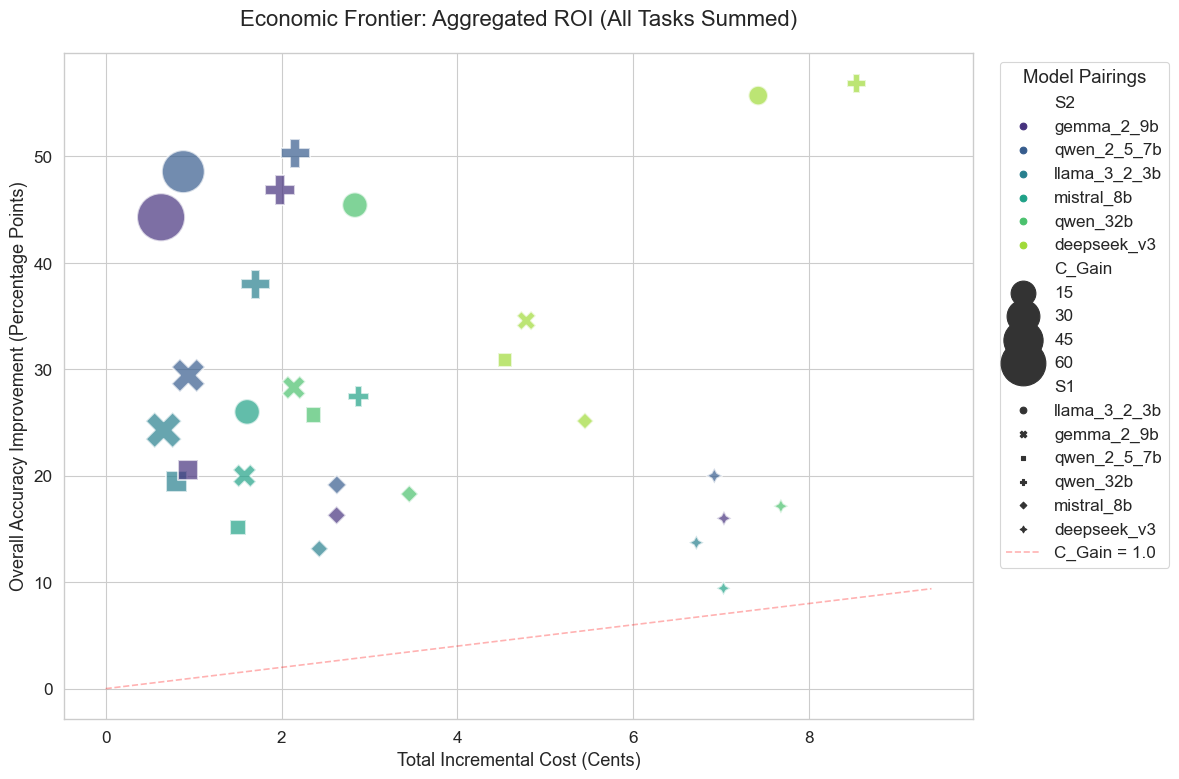

In [26]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. 配置区：价格表 ---
PRICING = {
    "mistral_8b":   {'in': 0.15, 'out': 0.15},
    "qwen_32b":     {'in': 0.08, 'out': 0.24},
    "deepseek_v3":  {'in': 0.3,  'out': 1.2},
    "qwen_2_5_7b":  {'in': 0.04, 'out': 0.1},
    "llama_3_2_3b": {'in': 0.02, 'out': 0.02},
    "gemma_2_9b":   {'in': 0.03, 'out': 0.09},
}

def normalize_tf(val):
    if isinstance(val, str):
        return val.strip().lower() == 'true'
    return bool(val)

def analyze_economic_oracle_aggregated(results_root):
    results_root = Path(results_root)
    known_models = sorted(list(PRICING.keys()), key=len, reverse=True)
    
    s1_registry = {} 
    s2_registry = {}
    
    for f in results_root.rglob("*.csv"):
        m_found = None
        for m in known_models:
            if f.name.startswith(m):
                m_found = m
                break
        if not m_found: continue
        
        task_part = f.name.replace(f"{m_found}_", "")
        if f.name.endswith("_s1.csv"):
            task_name = task_part.replace("_s1.csv", "")
            s1_registry[(m_found, task_name)] = f
        elif f.name.endswith("_s2.csv"):
            task_name = task_part.replace("_s2.csv", "")
            s2_registry[(m_found, task_name)] = f

    aggregation = {}

    for (s1_m, s1_t), s1_path in s1_registry.items():
        for (s2_m, s2_t), s2_path in s2_registry.items():
            if s1_t == s2_t and s1_m != s2_m:
                try:
                    df1 = pd.read_csv(s1_path)
                    df2 = pd.read_csv(s2_path)
                    merged = pd.merge(df1[['task', 'T_F']], 
                                     df2[['task', 'T_F', 'prompt_tokens', 'completion_tokens']],
                                     on='task', how='inner', suffixes=('_s1', '_s2'))
                    if merged.empty: continue
                    merged['T_F_s1'] = merged['T_F_s1'].apply(normalize_tf)
                    merged['T_F_s2'] = merged['T_F_s2'].apply(normalize_tf)

                    p1, p2 = PRICING[s1_m], PRICING[s2_m]
                    s1_cost = (merged['prompt_tokens'].sum() * p1['in'] + len(merged) * 20 * p1['out']) * 3 / 1e6
                    trigger_mask = (~merged['T_F_s1']) & (merged['T_F_s2'])
                    s2_cost = (merged.loc[trigger_mask, 'prompt_tokens'] * p2['in'] + 
                               merged.loc[trigger_mask, 'completion_tokens'] * p2['out']).sum() / 1e6

                    pair_key = (s1_m, s2_m)
                    if pair_key not in aggregation:
                        aggregation[pair_key] = {'n': 0, 's1': 0, 's2': 0, 'hyb': 0, 'cost': 0}
                    
                    stats = aggregation[pair_key]
                    stats['n'] += len(merged); stats['s1'] += merged['T_F_s1'].sum()
                    stats['s2'] += merged['T_F_s2'].sum(); stats['hyb'] += (merged['T_F_s1'] | merged['T_F_s2']).sum()
                    stats['cost'] += (s1_cost + s2_cost)
                except: continue

    all_stats = []
    for (s1_m, s2_m), d in aggregation.items():
        s1_a, s2_a, h_a = d['s1']/d['n'], d['s2']/d['n'], d['hyb']/d['n']
        mu = (h_a - s1_a) * 100; cost = d['cost'] * 100
        all_stats.append({"S1": s1_m, "S2": s2_m, "S1_Acc": s1_a, "S2_Acc": s2_a, 
                          "Hybrid_Acc": h_a, "MU_pts": mu, "Cost_Cents": cost, "C_Gain": mu/cost if cost>0 else 0})
    return pd.DataFrame(all_stats)

# --- 新增的可视化函数 ---
def plot_aggregated_frontier(df):
    if df.empty: return
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # 绘制气泡图
    # x: 成本, y: 提升点数, size: ROI (C_Gain), hue: S2模型 (展现S2的贡献)
    scatter = sns.scatterplot(
        data=df, x="Cost_Cents", y="MU_pts", size="C_Gain", hue="S2", style="S1",
        palette="viridis", sizes=(100, 1200), alpha=0.7, edgecolor="w", linewidth=1.5
    )
    
    # 标注 C_Gain = 1.0 的盈亏平衡线
    x_range = np.array([0, df['Cost_Cents'].max() * 1.1])
    plt.plot(x_range, x_range, color='red', linestyle='--', alpha=0.3, label='C_Gain = 1.0')

    plt.title("Economic Frontier: Aggregated ROI (All Tasks Summed)", fontsize=16, pad=20)
    plt.xlabel("Total Incremental Cost (Cents)", fontsize=13)
    plt.ylabel("Overall Accuracy Improvement (Percentage Points)", fontsize=13)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Model Pairings")
    plt.tight_layout()
    plt.savefig("ROI_Aggregated_Frontier.png", dpi=300)
    print("✅ 聚合分析图已保存为 ROI_Aggregated_Frontier.png")

if __name__ == "__main__":
    df_final = analyze_economic_oracle_aggregated("Results")
    if not df_final.empty:
        df_final = df_final.sort_values("C_Gain", ascending=False)
        df_final.to_csv("Aggregated_Analysis_Full.csv", index=False)
        print(df_final[['S1', 'S2', 'S1_Acc', 'S2_Acc', 'Hybrid_Acc', 'C_Gain']].head(10))
        plot_aggregated_frontier(df_final) # 调用画图

In [29]:
import pandas as pd
from pathlib import Path
import numpy as np

def normalize_tf(val):
    if isinstance(val, str):
        return val.strip().lower() == 'true'
    return bool(val)

def generate_full_baseline_stats(results_root):
    results_root = Path(results_root)
    models = ["mistral_8b", "qwen_32b", "deepseek_v3", "qwen_2_5_7b", "llama_3_2_3b", "gemma_2_9b"]
    
    # 存储每个模型各指标的列表
    model_stats = {m: {"s1_acc": [], "s2_acc": [], "s1_lat": [], "s2_lat": [], 
                       "s1_tk": [], "s2_tk": []} for m in models}

    print("🔍 深度扫描模型性能指标 (Acc, Latency, Tokens)...")
    
    for f in results_root.rglob("*.csv"):
        m_found = next((m for m in models if f.name.startswith(m)), None)
        if not m_found: continue
        
        try:
            df = pd.read_csv(f)
            # 预处理
            df['T_F'] = df['T_F'].apply(normalize_tf)
            avg_acc = df['T_F'].mean()
            avg_lat = df['latency_ms'].mean() if 'latency_ms' in df.columns else np.nan
            # 这里的 Token 通常是 prompt + completion
            df['total_tokens'] = df['prompt_tokens'] + df['completion_tokens']
            avg_tk = df['total_tokens'].mean() if 'total_tokens' in df.columns else np.nan

            if f.name.endswith("_s1.csv"):
                model_stats[m_found]["s1_acc"].append(avg_acc)
                model_stats[m_found]["s1_lat"].append(avg_lat)
                model_stats[m_found]["s1_tk"].append(avg_tk)
            elif f.name.endswith("_s2.csv"):
                model_stats[m_found]["s2_acc"].append(avg_acc)
                model_stats[m_found]["s2_lat"].append(avg_lat)
                model_stats[m_found]["s2_tk"].append(avg_tk)
                
        except Exception as e:
            print(f"⚠️ 跳过文件 {f.name}: {e}")

    # 汇总计算平均值
    final_rows = []
    for m, stats in model_stats.items():
        row = {"Model": m}
        # 计算各指标在所有任务上的平均值
        row["S1_Acc"] = np.mean(stats["s1_acc"]) if stats["s1_acc"] else np.nan
        row["S2_Acc"] = np.mean(stats["s2_acc"]) if stats["s2_acc"] else np.nan
        row["S1_Latency_ms"] = np.mean(stats["s1_lat"]) if stats["s1_lat"] else np.nan
        row["S2_Latency_ms"] = np.mean(stats["s2_lat"]) if stats["s2_lat"] else np.nan
        row["S1_Avg_Tokens"] = np.mean(stats["s1_tk"]) if stats["s1_tk"] else np.nan
        row["S2_Avg_Tokens"] = np.mean(stats["s2_tk"]) if stats["s2_tk"] else np.nan
        final_rows.append(row)

    df_final = pd.DataFrame(final_rows)
    # 按 S2_Acc 排序展现模型阶梯
    return df_final.sort_values("S2_Acc", ascending=False)

if __name__ == "__main__":
    results_path = "Results"
    df_baseline = generate_full_baseline_stats(results_path)
    
    # 打印格式化表格
    print("\n📊 Table 5.1: Aggregated Model Performance Baselines")
    print("="*100)
    # 格式化输出：准确率保留4位，延迟和Token保留0位（取整）
    pd.options.display.float_format = '{:,.2f}'.format
    print(df_baseline)
    print("="*100)
    
    df_baseline.to_csv("Comprehensive_Model_Baselines.csv", index=False)

🔍 深度扫描模型性能指标 (Acc, Latency, Tokens)...

📊 Table 5.1: Aggregated Model Performance Baselines
          Model  S1_Acc  S2_Acc  S1_Latency_ms  S2_Latency_ms  S1_Avg_Tokens  \
2   deepseek_v3    0.62    0.81       1,616.22       9,810.65          91.00   
3   qwen_2_5_7b    0.52    0.71         999.33       4,993.19          98.15   
1      qwen_32b    0.26    0.69       5,018.41      16,624.81         179.44   
5    gemma_2_9b    0.49    0.68         469.19       1,611.33         102.70   
4  llama_3_2_3b    0.26    0.54       1,652.47       9,380.55          93.13   
0    mistral_8b    0.60    0.41       1,123.41       5,712.52          98.42   

   S2_Avg_Tokens  
2         389.83  
3         397.57  
1         840.03  
5         302.12  
4         386.44  
0       1,006.97  


🔍 正在递归扫描目录: C:\Users\Han\Desktop\CL-uni tue\2025 SUMMER\Dual-Sys-Cong\Results
✅ 成功处理 84 个文件，热力图已保存。


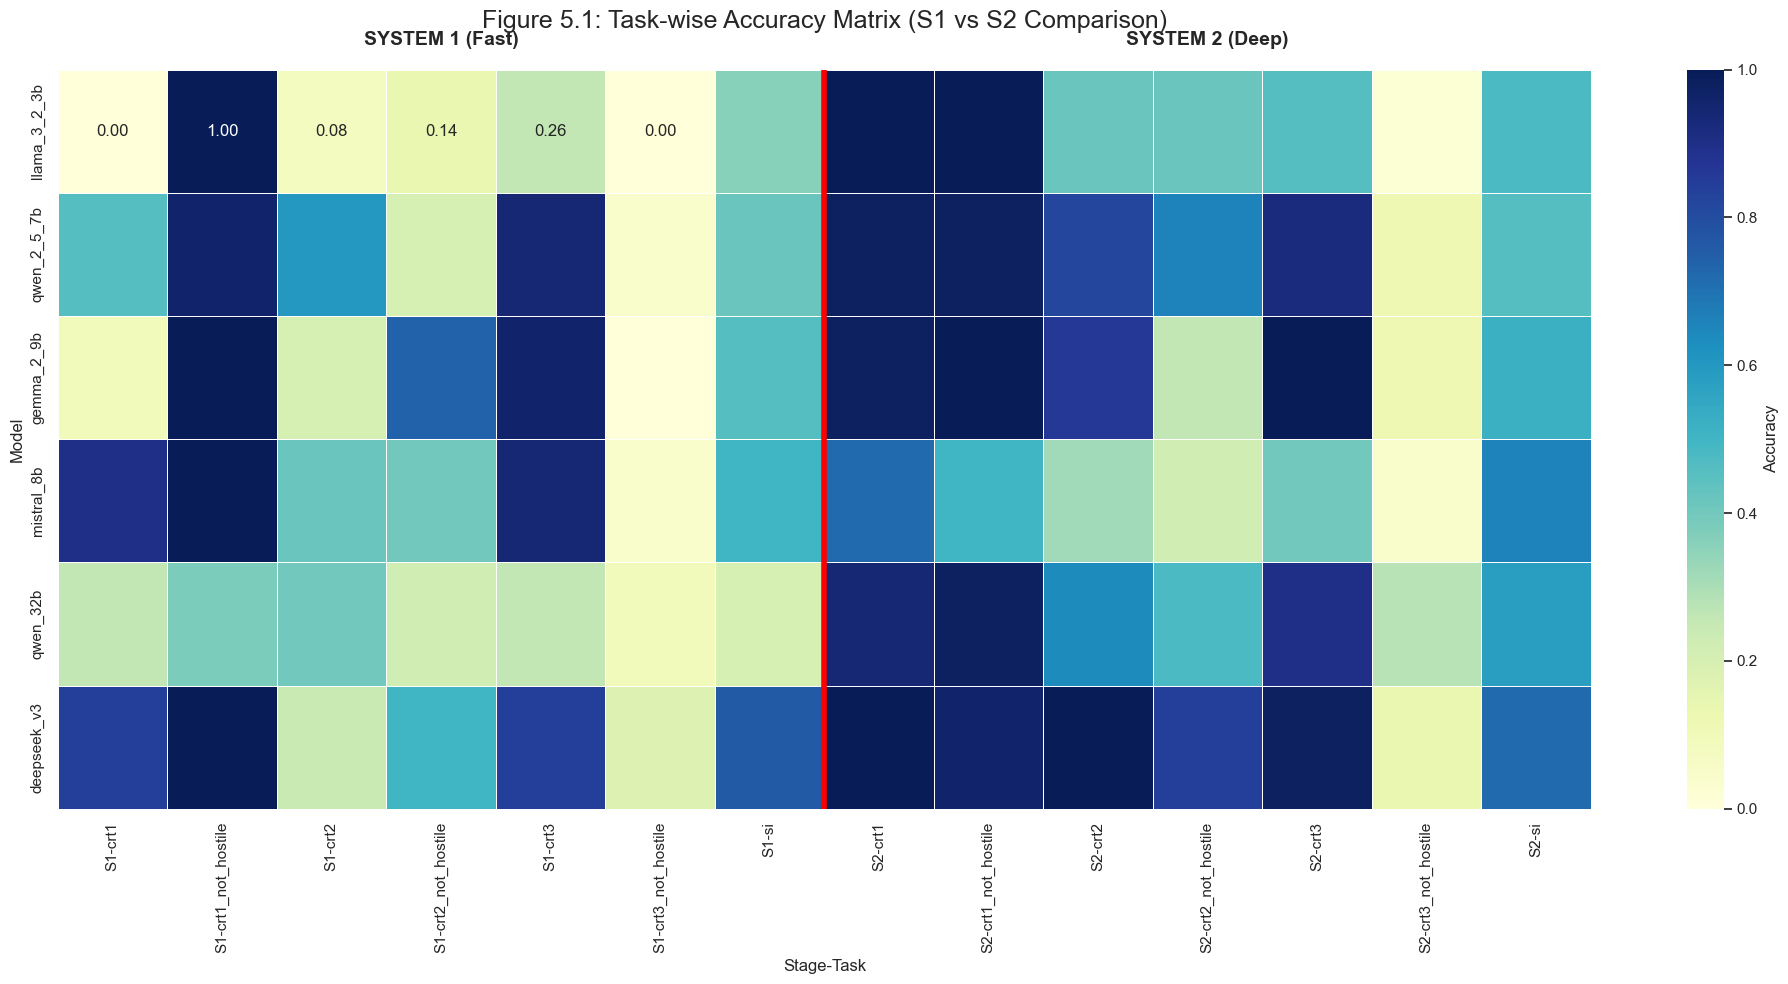

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def generate_benchmark_heatmap(results_root):
    results_root = Path(results_root)
    # 定义模型和任务顺序
    models = ["llama_3_2_3b", "qwen_2_5_7b", "gemma_2_9b", "mistral_8b", "qwen_32b", "deepseek_v3"]
    tasks = ["crt1", "crt1_not_hostile", "crt2", "crt2_not_hostile", "crt3", "crt3_not_hostile", "si"]
    
    data_list = []

    print(f"🔍 正在递归扫描目录: {results_root.absolute()}")

    # 使用 rglob("*_s1.csv") 和 rglob("*_s2.csv") 递归查找所有子文件夹里的文件
    for stage in ["s1", "s2"]:
        pattern = f"*_{stage}.csv"
        for file_path in results_root.rglob(pattern):
            # 从文件名反推 model 和 task
            # 文件名格式例: deepseek_v3_crt1_not_hostile_s1.csv
            file_name = file_path.name
            
            # 匹配模型名
            found_model = None
            for m in models:
                if file_name.startswith(m):
                    found_model = m
                    break
            
            if not found_model:
                continue
                
            # 提取任务名：去掉模型前缀和阶段后缀
            # 例如: deepseek_v3_crt1_s1.csv -> crt1
            task_part = file_name.replace(f"{found_model}_", "").replace(f"_{stage}.csv", "")
            
            if task_part in tasks:
                try:
                    df = pd.read_csv(file_path)
                    if 'T_F' in df.columns:
                        # 核心计算：计算 T_F 列的 True 比例
                        acc = df['T_F'].map(lambda x: str(x).strip().lower() == 'true').mean()
                        data_list.append({
                            "Model": found_model,
                            "Task": task_part,
                            "Stage": stage.upper(),
                            "Accuracy": acc
                        })
                    else:
                        print(f"⚠️ 文件 {file_name} 缺少 'T_F' 列")
                except Exception as e:
                    print(f"❌ 读取 {file_name} 出错: {e}")

    if not data_list:
        print("🚫 仍未找到数据。请确认：")
        print("1. Results 文件夹路径是否正确")
        print("2. 文件名是否严格遵循 [model]_[task]_[s1/s2].csv")
        return

    full_df = pd.DataFrame(data_list)
    
    # 构建透视表
    pivot_df = full_df.pivot_table(index="Model", columns=["Stage", "Task"], values="Accuracy")
    
    # 按照定义的顺序重排模型（行）
    pivot_df = pivot_df.reindex(models)
    
    # 绘图
    plt.figure(figsize=(20, 10))
    sns.set_theme(style="white")
    
    # 绘制热力图
    ax = sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="YlGnBu", 
                     linewidths=.5, cbar_kws={'label': 'Accuracy'},
                     vmin=0, vmax=1)

    # 在 S1 和 S2 之间画分界线
    num_tasks = len(tasks)
    plt.axvline(x=num_tasks, color='red', linewidth=4)
    
    plt.title("Figure 5.1: Task-wise Accuracy Matrix (S1 vs S2 Comparison)", fontsize=18, pad=30)
    plt.text(num_tasks/2, -0.2, 'SYSTEM 1 (Fast)', ha='center', weight='bold', fontsize=14)
    plt.text(num_tasks * 1.5, -0.2, 'SYSTEM 2 (Deep)', ha='center', weight='bold', fontsize=14)

    plt.tight_layout()
    plt.savefig("Benchmark_S1S2_Fixed.png", dpi=300)
    print(f"✅ 成功处理 {len(data_list)} 个文件，热力图已保存。")

if __name__ == "__main__":
    generate_benchmark_heatmap("Results")

🔍 正在执行分位数路由分析 (阈值比例: 0.37)...
✅ 分析完成！图表已保存。


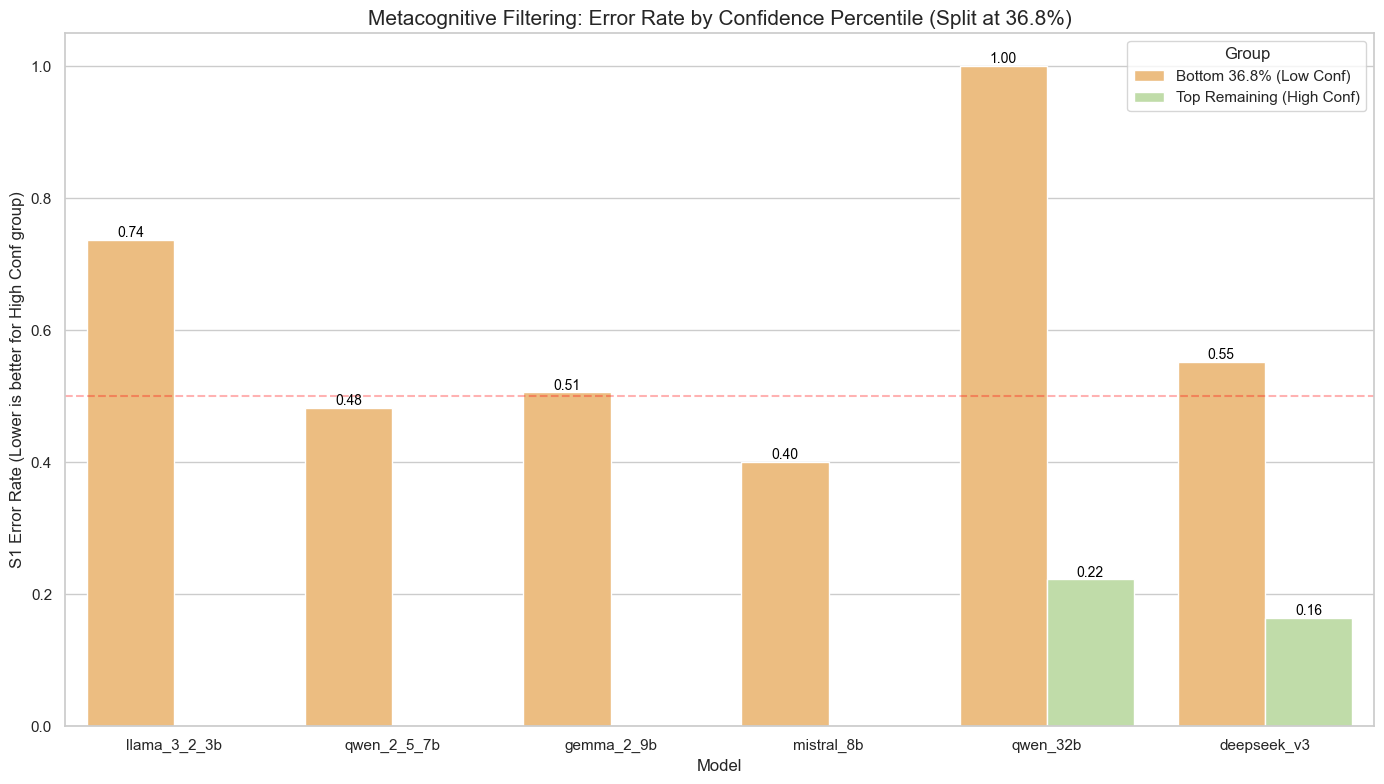

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

def analyze_confidence_percentile_reliability(results_root, percentile_ratio=1/np.e):
    results_root = Path(results_root)
    models = ["llama_3_2_3b", "qwen_2_5_7b", "gemma_2_9b", "mistral_8b", "qwen_32b", "deepseek_v3"]
    
    threshold_percentile = percentile_ratio * 100
    all_data = []

    print(f"🔍 正在执行分位数路由分析 (阈值比例: {percentile_ratio:.2f})...")

    # 汇总所有模型数据
    temp_dfs = []
    for file_path in results_root.rglob("*_s1.csv"):
        file_name = file_path.name
        found_model = next((m for m in models if file_name.startswith(m)), None)
        if not found_model: continue

        try:
            df = pd.read_csv(file_path)
            df['Model'] = found_model
            # 统一转换 T_F
            df['T_F'] = df['T_F'].map(lambda x: str(x).strip().lower() == 'true')
            temp_dfs.append(df[['Model', 'T_F', 's1_confidence']])
        except Exception as e:
            print(f"❌ 读取 {file_name} 失败: {e}")

    if not temp_dfs: return
    full_df = pd.concat(temp_dfs)

    stats = []
    for model in models:
        m_df = full_df[full_df['Model'] == model].copy()
        if m_df.empty: continue

        # 计算该模型的置信度阈值
        tau_s = np.percentile(m_df['s1_confidence'], threshold_percentile)
        
        # 模拟 Controller 分流
        low_conf_group = m_df[m_df['s1_confidence'] <= tau_s]
        high_conf_group = m_df[m_df['s1_confidence'] > tau_s]

        # 核心指标：
        # 1. 此时低置信度组的错误率 (应该显著高于全量平均错误率)
        low_conf_error_rate = (low_conf_group['T_F'] == False).mean()
        # 2. 此时高置信度组的错误率 (即漏网之鱼，应该尽可能低)
        high_conf_error_rate = (high_conf_group['T_F'] == False).mean()
        
        stats.append({
            "Model": model,
            "Group": f"Bottom {threshold_percentile:.1f}% (Low Conf)",
            "Error Rate": low_conf_error_rate,
            "Sample_Size": len(low_conf_group)
        })
        stats.append({
            "Model": model,
            "Group": "Top Remaining (High Conf)",
            "Error Rate": high_conf_error_rate,
            "Sample_Size": len(high_conf_group)
        })

    stats_df = pd.DataFrame(stats)

    # --- 绘图分析 ---
    plt.figure(figsize=(14, 8))
    sns.set_theme(style="whitegrid")
    
    # 绘制对比柱状图
    ax = sns.barplot(data=stats_df, x="Model", y="Error Rate", hue="Group", palette="Spectral")
    
    # 添加装饰
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.3, label="Random Guess Error Rate")
    plt.title(f"Metacognitive Filtering: Error Rate by Confidence Percentile (Split at {threshold_percentile:.1f}%)", fontsize=15)
    plt.ylabel("S1 Error Rate (Lower is better for High Conf group)", fontsize=12)
    
    # 在柱子上标注具体错误率
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.savefig("Confidence_Percentile_Effectiveness.png", dpi=300)
    print(f"✅ 分析完成！图表已保存。")

if __name__ == "__main__":
    analyze_confidence_percentile_reliability("Results")

🔍 正在深入分析采样一致性的决策价值...
✅ 采样可靠性分析图已保存。


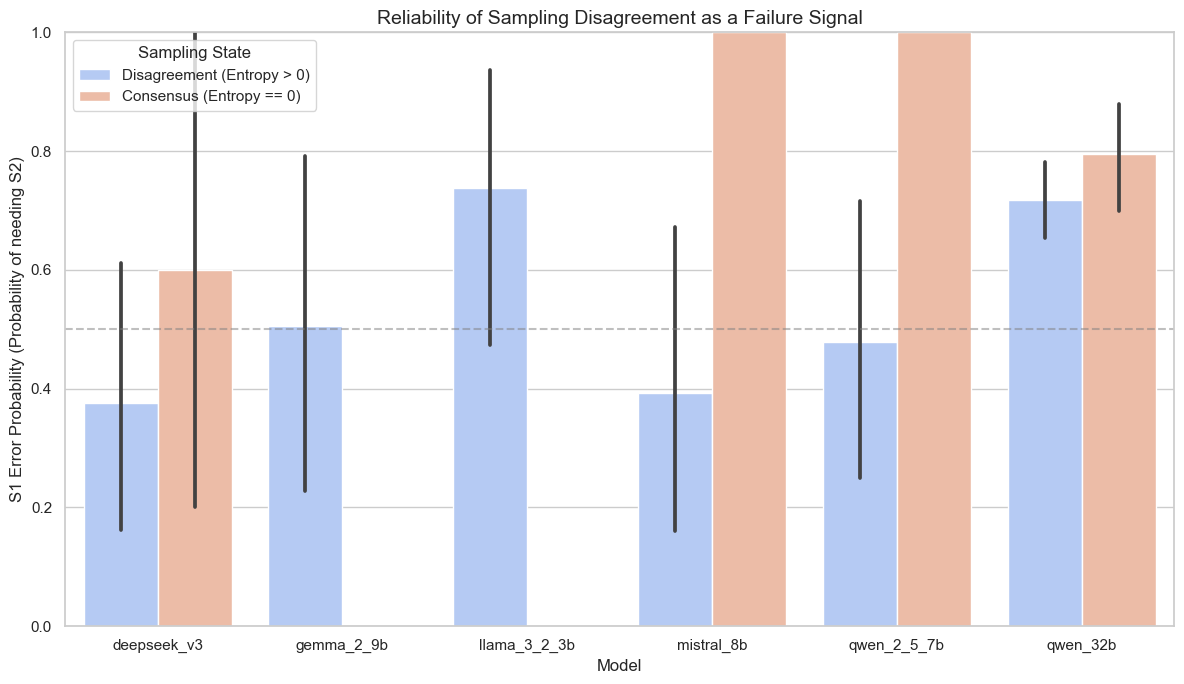

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def analyze_sampling_reliability(results_root):
    results_root = Path(results_root)
    models = ["llama_3_2_3b", "qwen_2_5_7b", "gemma_2_9b", "mistral_8b", "qwen_32b", "deepseek_v3"]
    
    reliability_data = []

    print(f"🔍 正在深入分析采样一致性的决策价值...")

    for file_path in results_root.rglob("*_s1.csv"):
        file_name = file_path.name
        found_model = next((m for m in models if file_name.startswith(m)), None)
        if not found_model: continue

        try:
            df = pd.read_csv(file_path)
            # 统一列名格式
            df['T_F'] = df['T_F'].map(lambda x: str(x).strip().lower() == 'true')
            
            # 定义两种触发 S2 的场景：
            # 1. Disagreement: 只要采样不完全一致 (Entropy > 0)
            # 2. Strong Consensus: 采样完全一致 (Entropy == 0)
            
            for condition in ['Disagreement (Entropy > 0)', 'Consensus (Entropy == 0)']:
                if 'Disagreement' in condition:
                    subset = df[df['consistency_entropy'] > 0]
                else:
                    subset = df[df['consistency_entropy'] == 0]
                
                if not subset.empty:
                    # 在这种状态下，S1 的错误率是多少？
                    # 如果 Disagreement 状态下错误率很高，说明采样分歧是极佳的 S2 触发信号
                    error_rate = (subset['T_F'] == False).mean()
                    reliability_data.append({
                        "Model": found_model,
                        "Sampling State": condition,
                        "S1 Error Rate": error_rate,
                        "Sample Size": len(subset)
                    })
        except Exception as e:
            print(f"❌ 分析 {file_name} 失败: {e}")

    df_plot = pd.DataFrame(reliability_data)

    # --- 绘图：采样状态 vs 错误率 ---
    plt.figure(figsize=(12, 7))
    sns.set_theme(style="whitegrid")
    
    ax = sns.barplot(data=df_plot, x="Model", y="S1 Error Rate", hue="Sampling State", palette="coolwarm")
    
    plt.title("Reliability of Sampling Disagreement as a Failure Signal", fontsize=14)
    plt.ylabel("S1 Error Probability (Probability of needing S2)", fontsize=12)
    plt.ylim(0, 1.0)
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5) # 50% 随机线
    
    plt.tight_layout()
    plt.savefig("Sampling_Reliability_Analysis.png", dpi=300)
    print("✅ 采样可靠性分析图已保存。")

if __name__ == "__main__":
    analyze_sampling_reliability("Results")

✅ 原始数据已保存：Scale_Aware_Raw_Results.csv
✅ 性能汇总矩阵已保存：Scale_Aware_Final_Matrix.csv

--- Table 5.3: Top 10 Performers ---
          S1           S2   S1_Acc  Hybrid_Acc  MU_pts     Cost     C_Gain
llama_3_2_3b   gemma_2_9b 0.262857    0.705714   310.0 0.866859 357.612945
llama_3_2_3b  qwen_2_5_7b 0.262857    0.748571   340.0 1.322836 257.023546
  gemma_2_9b llama_3_2_3b 0.494286    0.737143   170.0 0.717167 237.043813
    qwen_32b   gemma_2_9b 0.260000    0.728571   328.0 1.798020 182.422887
    qwen_32b llama_3_2_3b 0.260000    0.625714   256.0 1.441474 177.595989
 qwen_2_5_7b llama_3_2_3b 0.517143    0.708571   134.0 0.815156 164.385713
    qwen_32b  qwen_2_5_7b 0.260000    0.751429   344.0 2.222188 154.802384
  gemma_2_9b  qwen_2_5_7b 0.494286    0.788571   206.0 1.560775 131.985712
 qwen_2_5_7b   gemma_2_9b 0.517143    0.720000   142.0 1.201440 118.191504
  mistral_8b   gemma_2_9b 0.600000    0.754286   108.0 2.140137  50.464059

✅ 散点图已保存：Hybrid_ROI_Only.png


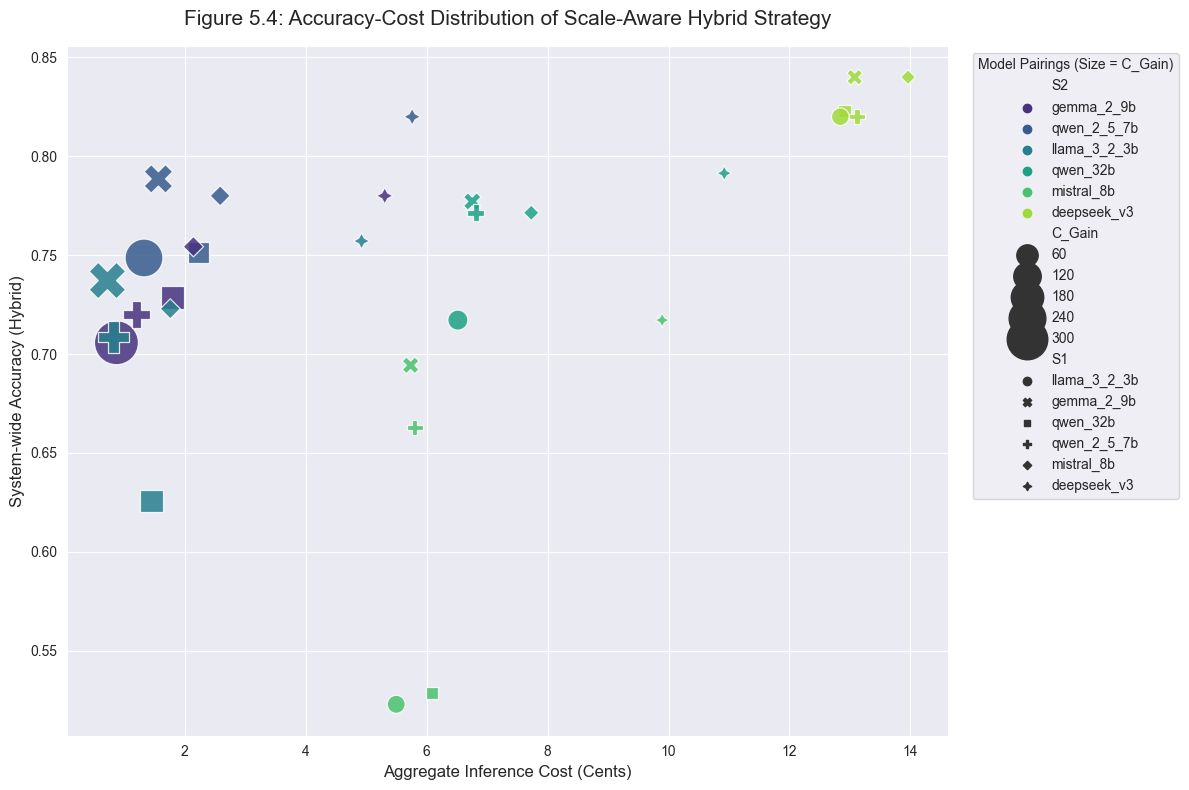

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# --- 1. 配置区 ---
PRICING = {
    "mistral_8b":   {'in': 0.15, 'out': 0.15, 'is_small': True},
    "qwen_32b":     {'in': 0.08, 'out': 0.24, 'is_small': False},
    "deepseek_v3":  {'in': 0.3,  'out': 1.2,  'is_small': False},
    "qwen_2_5_7b":  {'in': 0.04, 'out': 0.1,  'is_small': True},
    "llama_3_2_3b": {'in': 0.02, 'out': 0.02, 'is_small': True},
    "gemma_2_9b":   {'in': 0.03, 'out': 0.09, 'is_small': True},
}

PERCENTILE_RATIO = 1/np.e 

def run_hybrid_only_analysis(results_root):
    results_root = Path(results_root)
    models = list(PRICING.keys())
    s1_registry = {}
    
    # 1. 预载 S1
    for f in results_root.rglob("*_s1.csv"):
        m_name = next((m for m in models if f.name.startswith(m)), None)
        if m_name:
            task = f.name.replace(f"{m_name}_", "").replace("_s1.csv", "")
            df = pd.read_csv(f)
            df['T_F'] = df['T_F'].map(lambda x: str(x).strip().lower() == 'true')
            s1_registry[(m_name, task)] = df

    final_results = []
    s2_files = list(results_root.rglob("*_s2.csv"))
    
    # 2. 核心计算
    for f_s2 in s2_files:
        s2_m = next((m for m in models if f_s2.name.startswith(m)), None)
        if not s2_m: continue
        s2_task = f_s2.name.replace(f"{s2_m}_", "").replace("_s2.csv", "")
        df_s2 = pd.read_csv(f_s2)
        df_s2['T_F'] = df_s2['T_F'].map(lambda x: str(x).strip().lower() == 'true')

        for s1_m in models:
            if s1_m == s2_m: continue 
            if (s1_m, s2_task) not in s1_registry: continue
            
            df_s1 = s1_registry[(s1_m, s2_task)]
            merged = pd.merge(df_s1, df_s2, on='id', suffixes=('_s1', '_s2'))
            if merged.empty: continue

            # --- Scale-Aware Controller 逻辑 ---
            is_small = PRICING[s1_m]['is_small']
            tau_s = np.percentile(merged['s1_confidence'], PERCENTILE_RATIO * 100)
            
            if is_small:
                trigger = (merged['consistency_entropy'] > 0)
            else:
                trigger = (merged['consistency_entropy'] > 0) | (merged['s1_confidence'] <= tau_s)

            # --- 指标计算 ---
            n = len(merged)
            s1_acc = merged['T_F_s1'].mean()
            hybrid_acc = (merged['T_F_s1'] | (trigger & merged['T_F_s2'])).mean()
            
            p1, p2 = PRICING[s1_m], PRICING[s2_m]
            c_s1 = (merged['prompt_tokens_s1'].sum() * p1['in'] + n * 20 * p1['out']) * 3 / 1e6
            c_s2 = (merged.loc[trigger, 'prompt_tokens_s2'] * p2['in'] + 
                    merged.loc[trigger, 'completion_tokens_s2'] * p2['out']).sum() / 1e6
            total_cost = (c_s1 + c_s2) * 100

            final_results.append({
                "S1": s1_m, "S2": s2_m, "Task": s2_task,
                "S1_Acc": s1_acc, "Hybrid_Acc": hybrid_acc,
                "MU_pts": (hybrid_acc - s1_acc) * 100, "Cost": total_cost
            })

    # --- 3. 结果保存逻辑 ---
    
    # 保存包含所有任务细节的原始数据 (Raw Data)
    raw_df = pd.DataFrame(final_results)
    raw_df.to_csv("Scale_Aware_Raw_Results.csv", index=False)
    print("✅ 原始数据已保存：Scale_Aware_Raw_Results.csv")

    # 聚合汇总 (Aggregation)
    agg_df = raw_df.groupby(['S1', 'S2']).agg({
        'S1_Acc': 'mean', 
        'Hybrid_Acc': 'mean', 
        'MU_pts': 'sum', 
        'Cost': 'sum'
    }).reset_index()
    
    # 计算 C_Gain 并排序
    agg_df['C_Gain'] = agg_df['MU_pts'] / agg_df['Cost']
    agg_df = agg_df.sort_values("C_Gain", ascending=False)
    
    # 保存汇总后的性能矩阵
    agg_df.to_csv("Scale_Aware_Final_Matrix.csv", index=False)
    print("✅ 性能汇总矩阵已保存：Scale_Aware_Final_Matrix.csv")

    print("\n--- Table 5.3: Top 10 Performers ---")
    print(agg_df.head(10).to_string(index=False))

    # --- 4. 绘制 Figure 5.4 ---
    plt.figure(figsize=(12, 8))
    sns.set_style("darkgrid")

    ax = sns.scatterplot(
        data=agg_df, x="Cost", y="Hybrid_Acc", 
        hue="S2", style="S1", size="C_Gain", 
        sizes=(100, 1000), alpha=0.85, palette="viridis"
    )

    plt.title("Figure 5.4: Accuracy-Cost Distribution of Scale-Aware Hybrid Strategy", fontsize=15, pad=15)
    plt.xlabel("Aggregate Inference Cost (Cents)", fontsize=12)
    plt.ylabel("System-wide Accuracy (Hybrid)", fontsize=12)
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Model Pairings (Size = C_Gain)")
    plt.tight_layout()
    plt.savefig("Hybrid_ROI_Only.png", dpi=300)
    print("\n✅ 散点图已保存：Hybrid_ROI_Only.png")
    
    return agg_df

if __name__ == "__main__":
    df = run_hybrid_only_analysis("Results")

✅ 图 A 已保存：Confidence_Calibration_Gap.png
✅ 图 B 已保存：Sampling_Entropy_Reliability.png


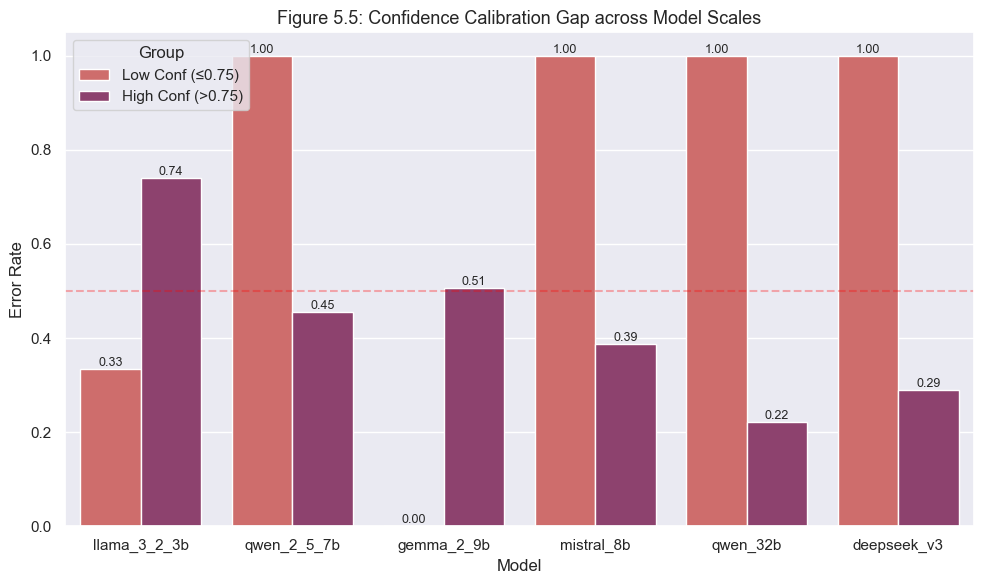

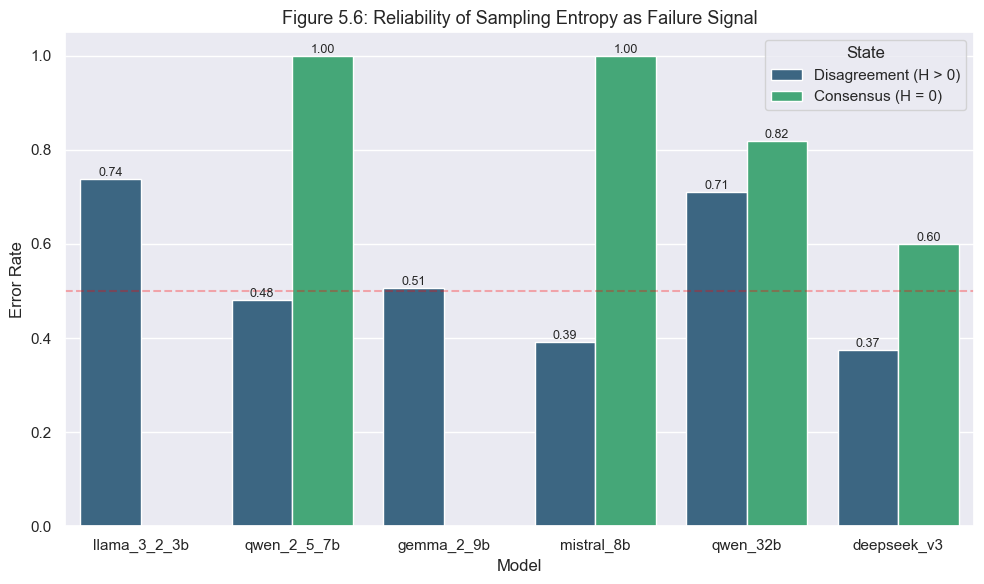

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

def run_split_metacognitive_analysis(results_root, conf_threshold=0.75):
    results_root = Path(results_root)
    models = ["llama_3_2_3b", "qwen_2_5_7b", "gemma_2_9b", "mistral_8b", "qwen_32b", "deepseek_v3"]
    
    all_data_list = []
    for file_path in results_root.rglob("*_s1.csv"):
        m_name = next((m for m in models if file_path.name.startswith(m)), None)
        if not m_name: continue
        try:
            df = pd.read_csv(file_path)
            df['Model'] = m_name
            df['T_F'] = df['T_F'].map(lambda x: str(x).strip().lower() == 'true')
            all_data_list.append(df[['Model', 'T_F', 's1_confidence', 'consistency_entropy']])
        except Exception as e:
            print(f"❌ 读取 {file_path.name} 失败: {e}")

    full_df = pd.concat(all_data_list)
    sns.set_theme(style="darkgrid")

    # --- 1. 绘制图 A: 置信度校准差距 ---
    conf_stats = []
    for model in models:
        m_df = full_df[full_df['Model'] == model].copy()
        if m_df.empty: continue
        low_c = m_df[m_df['s1_confidence'] <= conf_threshold]
        high_c = m_df[m_df['s1_confidence'] > conf_threshold]
        conf_stats.append({"Model": model, "Group": f"Low Conf (≤{conf_threshold})", "Error Rate": (low_c['T_F'] == False).mean()})
        conf_stats.append({"Model": model, "Group": f"High Conf (>{conf_threshold})", "Error Rate": (high_c['T_F'] == False).mean()})

    plt.figure(figsize=(10, 6))
    ax1 = sns.barplot(data=pd.DataFrame(conf_stats), x="Model", y="Error Rate", hue="Group", palette="flare")
    plt.title("Figure 5.5: Confidence Calibration Gap across Model Scales", fontsize=13)
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.3)
    for p in ax1.patches:
        ax1.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.savefig("Confidence_Calibration_Gap.png", dpi=300)
    print("✅ 图 A 已保存：Confidence_Calibration_Gap.png")

    # --- 2. 绘制图 B: 采样一致性可靠性 ---
    samp_stats = []
    for model in models:
        m_df = full_df[full_df['Model'] == model].copy()
        if m_df.empty: continue
        disagree = m_df[m_df['consistency_entropy'] > 0]
        consensus = m_df[m_df['consistency_entropy'] == 0]
        samp_stats.append({"Model": model, "State": "Disagreement (H > 0)", "Error Rate": (disagree['T_F'] == False).mean()})
        samp_stats.append({"Model": model, "State": "Consensus (H = 0)", "Error Rate": (consensus['T_F'] == False).mean()})

    plt.figure(figsize=(10, 6))
    ax2 = sns.barplot(data=pd.DataFrame(samp_stats), x="Model", y="Error Rate", hue="State", palette="viridis")
    plt.title("Figure 5.6: Reliability of Sampling Entropy as Failure Signal", fontsize=13)
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.3)
    for p in ax2.patches:
        ax2.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.savefig("Sampling_Entropy_Reliability.png", dpi=300)
    print("✅ 图 B 已保存：Sampling_Entropy_Reliability.png")

if __name__ == "__main__":
    run_split_metacognitive_analysis("Results")

✅ 完成！Llama/Gemma 已执行仅熵拦截，图表保存为 Optimized_Joint_Trigger_Analysis.png


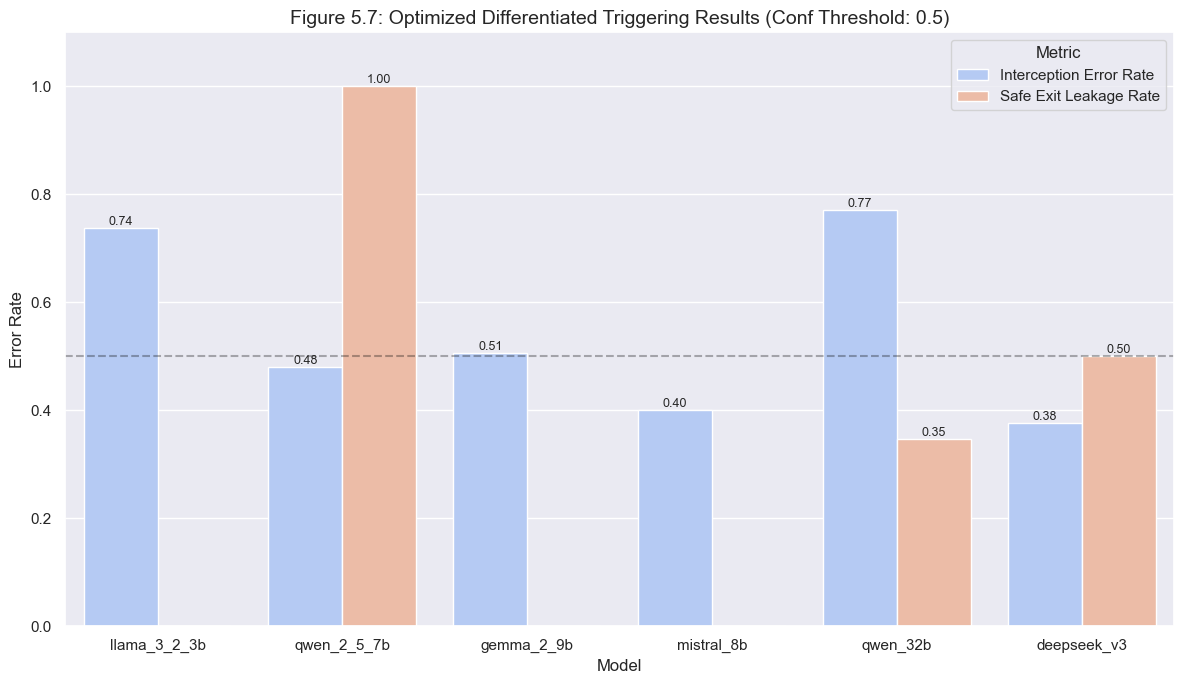

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

def run_optimized_joint_trigger_analysis(results_root, conf_threshold=0.5):
    results_root = Path(results_root)
    models = ["llama_3_2_3b", "qwen_2_5_7b", "gemma_2_9b", "mistral_8b", "qwen_32b", "deepseek_v3"]
    
    all_data_list = []
    for file_path in results_root.rglob("*_s1.csv"):
        m_name = next((m for m in models if file_path.name.startswith(m)), None)
        if not m_name: continue
        try:
            df = pd.read_csv(file_path)
            df['Model'] = m_name
            df['T_F'] = df['T_F'].map(lambda x: str(x).strip().lower() == 'true')
            all_data_list.append(df[['Model', 'T_F', 's1_confidence', 'consistency_entropy']])
        except Exception as e:
            print(f"❌ 读取 {file_path.name} 失败: {e}")

    full_df = pd.concat(all_data_list)
    sns.set_theme(style="darkgrid")

    final_stats = []
    for model in models:
        m_df = full_df[full_df['Model'] == model].copy()
        if m_df.empty: continue
        
        # --- 针对性的拦截逻辑 ---
        if "llama" in model or "gemma" in model:
            # Llama & Gemma: 仅依靠采样熵拦截
            # 逻辑：只要有分歧就拦截；只有完全一致才放行
            triggered = m_df[m_df['consistency_entropy'] > 0]
            exited = m_df[m_df['consistency_entropy'] == 0]
            strategy_label = "Entropy-Only (Ignore Conf)"
        else:
            # 其他模型: 联合拦截 (熵 > 0 OR 置信度 <= 0.5)
            # 逻辑：只要分歧 OR 置信度低就拦截；只有一致且高置信度才放行
            triggered = m_df[(m_df['s1_confidence'] <= conf_threshold) | (m_df['consistency_entropy'] > 0)]
            exited = m_df[(m_df['s1_confidence'] > conf_threshold) & (m_df['consistency_entropy'] == 0)]
            strategy_label = f"Joint (Conf<{conf_threshold} | Ent)"

        # 1. 拦截到的错误率 (反映拦截的精准度/必要性)
        interception_precision = (triggered['T_F'] == False).mean() if not triggered.empty else 0
        # 2. 漏网之鱼的错误率 (反映放行后的安全性)
        leakage_rate = (exited['T_F'] == False).mean() if not exited.empty else 0
        
        final_stats.append({"Model": model, "Metric": "Interception Error Rate", "Value": interception_precision})
        final_stats.append({"Model": model, "Metric": "Safe Exit Leakage Rate", "Value": leakage_rate})

    # 绘制分析图
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(data=pd.DataFrame(final_stats), x="Model", y="Value", hue="Metric", palette="coolwarm")
    
    plt.title(f"Figure 5.7: Optimized Differentiated Triggering Results (Conf Threshold: {conf_threshold})", fontsize=14)
    plt.ylabel("Error Rate")
    plt.axhline(0.5, color='black', linestyle='--', alpha=0.3)
    plt.ylim(0, 1.1)

    for p in ax.patches:
        height = p.get_height()
        if not np.isnan(height) and height > 0:
            ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig("Optimized_Joint_Trigger_Analysis.png", dpi=300)
    print(f"✅ 完成！Llama/Gemma 已执行仅熵拦截，图表保存为 Optimized_Joint_Trigger_Analysis.png")

if __name__ == "__main__":
    run_optimized_joint_trigger_analysis("Results")

✅ 纯净化信号分析完成！结果已保存为 Signal_Purity_Analysis.png


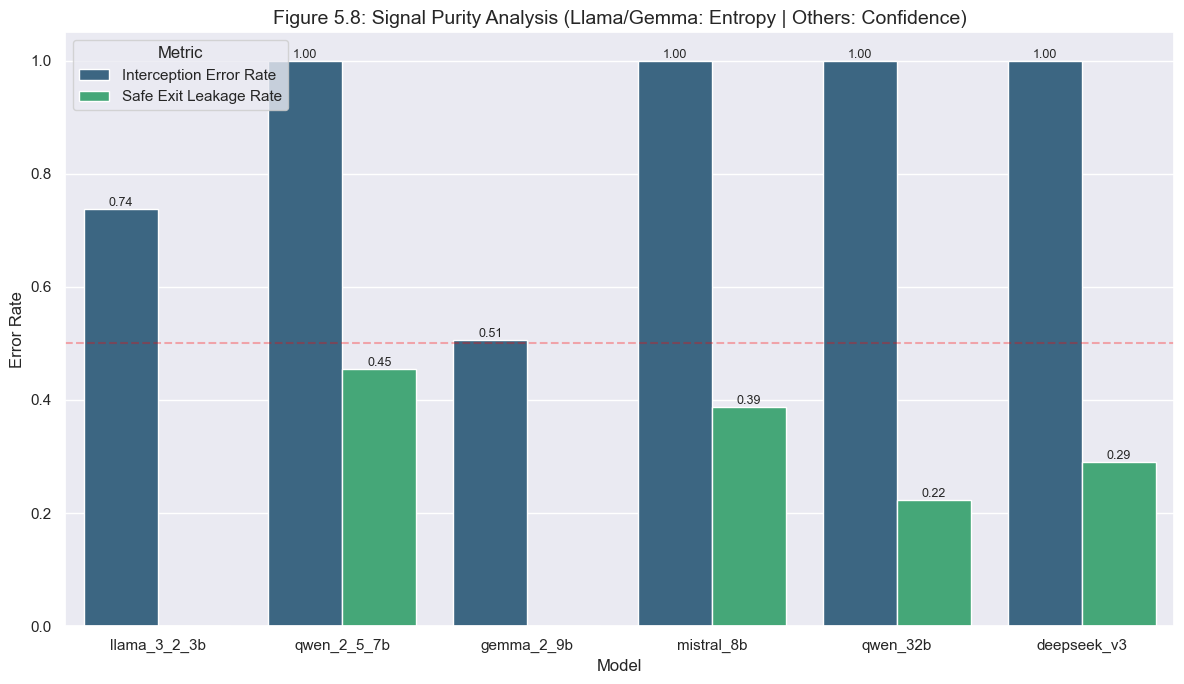

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

def run_pure_signal_split_analysis(results_root, conf_threshold=0.5):
    results_root = Path(results_root)
    models = ["llama_3_2_3b", "qwen_2_5_7b", "gemma_2_9b", "mistral_8b", "qwen_32b", "deepseek_v3"]
    
    all_data_list = []
    for file_path in results_root.rglob("*_s1.csv"):
        m_name = next((m for m in models if file_path.name.startswith(m)), None)
        if not m_name: continue
        try:
            df = pd.read_csv(file_path)
            df['Model'] = m_name
            df['T_F'] = df['T_F'].map(lambda x: str(x).strip().lower() == 'true')
            all_data_list.append(df[['Model', 'T_F', 's1_confidence', 'consistency_entropy']])
        except Exception as e:
            print(f"❌ 读取 {file_path.name} 失败: {e}")

    full_df = pd.concat(all_data_list)
    sns.set_theme(style="darkgrid")

    final_stats = []
    for model in models:
        m_df = full_df[full_df['Model'] == model].copy()
        if m_df.empty: continue
        
        # --- 核心修改：纯净化信号路由 ---
        if "llama" in model or "gemma" in model:
            # Llama & Gemma: 纯熵拦截 (熵 > 0 拦截，熵 = 0 放行)
            triggered = m_df[m_df['consistency_entropy'] > 0]
            exited = m_df[m_df['consistency_entropy'] == 0]
            strategy_label = "Entropy-Only"
        else:
            # 其他模型: 纯置信度拦截 (<= 0.5 拦截，> 0.5 放行)
            triggered = m_df[m_df['s1_confidence'] <= conf_threshold]
            exited = m_df[m_df['s1_confidence'] > conf_threshold]
            strategy_label = f"Confidence-Only (Thres={conf_threshold})"

        # 计算指标
        interception_precision = (triggered['T_F'] == False).mean() if not triggered.empty else 0
        leakage_rate = (exited['T_F'] == False).mean() if not exited.empty else 0
        
        final_stats.append({"Model": model, "Metric": "Interception Error Rate", "Value": interception_precision})
        final_stats.append({"Model": model, "Metric": "Safe Exit Leakage Rate", "Value": leakage_rate})

    # 绘图
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(data=pd.DataFrame(final_stats), x="Model", y="Value", hue="Metric", palette="viridis")
    
    plt.title("Figure 5.8: Signal Purity Analysis (Llama/Gemma: Entropy | Others: Confidence)", fontsize=14)
    plt.ylabel("Error Rate")
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.3)
    
    for p in ax.patches:
        height = p.get_height()
        if not np.isnan(height) and height > 0:
            ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig("Signal_Purity_Analysis.png", dpi=300)
    print("✅ 纯净化信号分析完成！结果已保存为 Signal_Purity_Analysis.png")

if __name__ == "__main__":
    run_pure_signal_split_analysis("Results")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# --- 1. 配置区 ---
PRICING = {
    "mistral_8b":   {'in': 0.15, 'out': 0.15, 'is_small': True},
    "qwen_32b":     {'in': 0.08, 'out': 0.24, 'is_small': False},
    "deepseek_v3":  {'in': 0.3,  'out': 1.2,  'is_small': False},
    "qwen_2_5_7b":  {'in': 0.04, 'out': 0.1,  'is_small': True},
    "llama_3_2_3b": {'in': 0.02, 'out': 0.02, 'is_small': True},
    "gemma_2_9b":   {'in': 0.03, 'out': 0.09, 'is_small': True},
}

PERCENTILE_RATIO = 1/np.e 

def run_full_36_analysis(results_root):
    results_root = Path(results_root)
    models = list(PRICING.keys())
    s1_registry = {}
    
    # 1. 预载 S1
    for f in results_root.rglob("*_s1.csv"):
        m_name = next((m for m in models if f.name.startswith(m)), None)
        if m_name:
            task = f.name.replace(f"{m_name}_", "").replace("_s1.csv", "")
            df = pd.read_csv(f)
            df['T_F'] = df['T_F'].map(lambda x: str(x).strip().lower() == 'true')
            s1_registry[(m_name, task)] = df

    final_results = []
    s2_files = list(results_root.rglob("*_s2.csv"))
    
    # 2. 核心计算
    for f_s2 in s2_files:
        s2_m = next((m for m in models if f_s2.name.startswith(m)), None)
        if not s2_m: continue
        s2_task = f_s2.name.replace(f"{s2_m}_", "").replace("_s2.csv", "")
        df_s2 = pd.read_csv(f_s2)
        df_s2['T_F'] = df_s2['T_F'].map(lambda x: str(x).strip().lower() == 'true')

        for s1_m in models:
            # --- 修改点：不再跳过 s1_m == s2_m ---
            if (s1_m, s2_task) not in s1_registry: continue
            
            df_s1 = s1_registry[(s1_m, s2_task)]
            merged = pd.merge(df_s1, df_s2, on='id', suffixes=('_s1', '_s2'))
            if merged.empty: continue

            # --- Scale-Aware Controller 逻辑 ---
            is_small = PRICING[s1_m]['is_small']
            tau_s = np.percentile(merged['s1_confidence'], PERCENTILE_RATIO * 100)
            
            if is_small:
                trigger = (merged['consistency_entropy'] > 0)
            else:
                trigger = (merged['consistency_entropy'] > 0) | (merged['s1_confidence'] <= tau_s)

            # --- 指标计算 ---
            n = len(merged)
            s1_acc = merged['T_F_s1'].mean()
            # 注意：即便 S1==S2，如果触发了 trigger，依然会计入 S2 的成本和结果（模拟真实路由逻辑）
            hybrid_acc = (merged['T_F_s1'] | (trigger & merged['T_F_s2'])).mean()
            
            p1, p2 = PRICING[s1_m], PRICING[s2_m]
            c_s1 = (merged['prompt_tokens_s1'].sum() * p1['in'] + n * 20 * p1['out']) * 3 / 1e6
            c_s2 = (merged.loc[trigger, 'prompt_tokens_s2'] * p2['in'] + 
                    merged.loc[trigger, 'completion_tokens_s2'] * p2['out']).sum() / 1e6
            total_cost = (c_s1 + c_s2) * 100

            final_results.append({
                "S1": s1_m, "S2": s2_m, "Task": s2_task,
                "S1_Acc": s1_acc, "Hybrid_Acc": hybrid_acc,
                "MU_pts": (hybrid_acc - s1_acc) * 100, "Cost": total_cost
            })

    # --- 3. 聚合与保存 ---
    raw_df = pd.DataFrame(final_results)
    
    agg_df = raw_df.groupby(['S1', 'S2']).agg({
        'S1_Acc': 'mean', 
        'Hybrid_Acc': 'mean', 
        'MU_pts': 'sum', 
        'Cost': 'sum'
    }).reset_index()
    
    agg_df['C_Gain'] = agg_df['MU_pts'] / agg_df['Cost']
    # 填充 NaN（如果成本和提升均为 0）
    agg_df['C_Gain'] = agg_df['C_Gain'].fillna(0)
    
    # 按 S1 排序以便观察 6x6 结构
    agg_df = agg_df.sort_values(["S1", "S2"])
    
    # 保存全部 36 条记录
    agg_df.to_csv("Scale_Aware_Full_36_Matrix.csv", index=False)
    
    print(f"✅ 成功处理组合数量: {len(agg_df)}")
    print("✅ 完整 36 行矩阵已保存：Scale_Aware_Full_36_Matrix.csv")
    
    return agg_df

if __name__ == "__main__":
    df = run_full_36_analysis("Results")

✅ 成功处理组合数量: 36
✅ 完整 36 行矩阵已保存：Scale_Aware_Full_36_Matrix.csv



Table 8: Theoretical Upper Bound (Oracle) Performance Matrix (Top 10 by CGain)
----------------------------------------------------------------------------------------------------
    S1_Model     S2_Model  S1_Acc  S2_Acc  Oracle_Acc  MU_pts  Cost  CGain
llama_3_2_3b   gemma_2_9b    0.26    0.68        0.71   44.29  0.07 615.60
llama_3_2_3b  qwen_2_5_7b    0.26    0.71        0.75   48.57  0.11 440.08
  gemma_2_9b llama_3_2_3b    0.49    0.54        0.74   24.29  0.07 339.40
  gemma_2_9b  qwen_2_5_7b    0.49    0.71        0.79   29.43  0.11 263.53
 qwen_2_5_7b llama_3_2_3b    0.52    0.54        0.71   19.43  0.08 230.20
    qwen_32b   gemma_2_9b    0.26    0.68        0.73   46.86  0.21 219.86
 qwen_2_5_7b   gemma_2_9b    0.52    0.68        0.72   20.57  0.10 208.92
    qwen_32b llama_3_2_3b    0.26    0.54        0.64   38.00  0.18 207.98
    qwen_32b  qwen_2_5_7b    0.26    0.71        0.76   50.29  0.25 202.90
llama_3_2_3b   mistral_8b    0.26    0.41        0.52   26.00  0.22 1

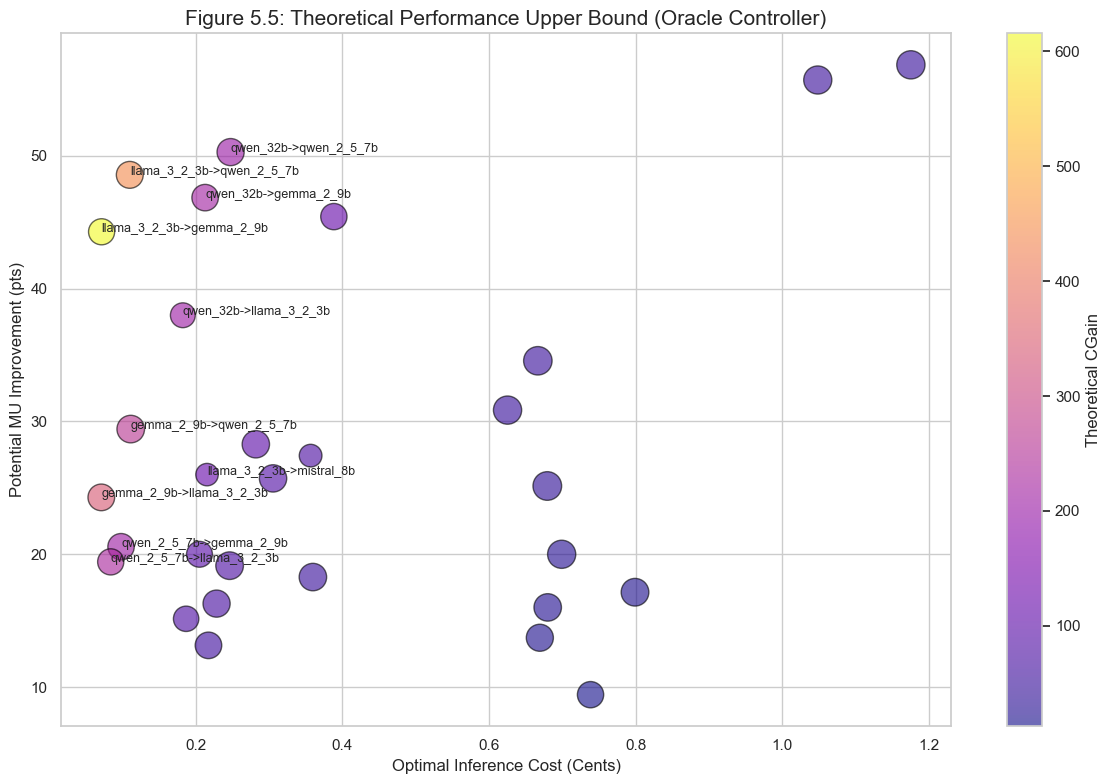

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# 建议执行: pip install adjustText
try:
    from adjust_text import adjust_text
    HAS_ADJUST = True
except ImportError:
    HAS_ADJUST = False

# --- 1. 配置区 ---
PRICING = {
    "llama_3_2_3b": {'in': 0.02, 'out': 0.02, 'is_small': True},
    "gemma_2_9b":   {'in': 0.03, 'out': 0.09, 'is_small': True},
    "qwen_2_5_7b":  {'in': 0.04, 'out': 0.1,  'is_small': True},
    "mistral_8b":   {'in': 0.15, 'out': 0.15, 'is_small': True},
    "qwen_32b":     {'in': 0.08, 'out': 0.24, 'is_small': False},
    "deepseek_v3":  {'in': 0.3,  'out': 1.2,  'is_small': False},
}

def run_oracle_performance_analysis(results_root):
    results_root = Path(results_root)
    models = list(PRICING.keys())
    s1_registry = {}
    
    for f in results_root.rglob("*_s1.csv"):
        m_name = next((m for m in models if f.name.startswith(m)), None)
        if m_name:
            task = f.name.replace(f"{m_name}_", "").replace("_s1.csv", "")
            df = pd.read_csv(f)
            df['T_F'] = df['T_F'].map(lambda x: str(x).strip().lower() == 'true')
            s1_registry[(m_name, task)] = df

    oracle_results = []
    s2_files = list(results_root.rglob("*_s2.csv"))
    
    for f_s2 in s2_files:
        s2_m = next((m for m in models if f_s2.name.startswith(m)), None)
        if not s2_m: continue
        s2_task = f_s2.name.replace(f"{s2_m}_", "").replace("_s2.csv", "")
        df_s2 = pd.read_csv(f_s2)
        df_s2['T_F'] = df_s2['T_F'].map(lambda x: str(x).strip().lower() == 'true')

        for s1_m in models:
            if s1_m == s2_m: continue 
            if (s1_m, s2_task) not in s1_registry: continue
            
            df_s1 = s1_registry[(s1_m, s2_task)]
            merged = pd.merge(df_s1, df_s2, on='id', suffixes=('_s1', '_s2'))
            if merged.empty: continue

            # --- 核心逻辑：理论最优控制器 (Oracle) ---
            # 仅当 S1 错且 S2 对时才触发 (这是理论上的最小触发集合，达到最大 Acc 同时成本最低)
            oracle_trigger = (merged['T_F_s1'] == False) & (merged['T_F_s2'] == True)
            
            # 性能计算
            s1_acc = merged['T_F_s1'].mean()
            s2_acc = merged['T_F_s2'].mean()
            # 理论最高准确率是 S1 和 S2 的并集
            oracle_acc = (merged['T_F_s1'] | merged['T_F_s2']).mean()
            mu_pts = (oracle_acc - s1_acc) * 100
            
            # 成本计算 (只在 Oracle 触发时计算 S2 成本)
            p1, p2 = PRICING[s1_m], PRICING[s2_m]
            c_s1 = (merged['prompt_tokens_s1'].sum() * p1['in'] + len(merged) * 20 * p1['out']) * 3 / 1e6
            c_s2 = (merged.loc[oracle_trigger, 'prompt_tokens_s2'] * p2['in'] + 
                    merged.loc[oracle_trigger, 'completion_tokens_s2'] * p2['out']).sum() / 1e6
            total_cost = (c_s1 + c_s2) * 100

            oracle_results.append({
                "S1_Model": s1_m, "S2_Model": s2_m, 
                "S1_Acc": s1_acc, "S2_Acc": s2_acc, "Oracle_Acc": oracle_acc,
                "MU_pts": mu_pts, "Cost": total_cost
            })

    # --- 数据聚合 ---
    perf_df = pd.DataFrame(oracle_results).groupby(['S1_Model', 'S2_Model']).mean().reset_index()
    perf_df['CGain'] = perf_df['MU_pts'] / (perf_df['Cost'] + 1e-9)

    # --- 打印表格 ---
    print("\n" + "="*100)
    print("Table 8: Theoretical Upper Bound (Oracle) Performance Matrix (Top 10 by CGain)")
    print("-" * 100)
    display_cols = ['S1_Model', 'S2_Model', 'S1_Acc', 'S2_Acc', 'Oracle_Acc', 'MU_pts', 'Cost', 'CGain']
    top_10 = perf_df.sort_values('CGain', ascending=False).head(10)
    print(top_10[display_cols].to_string(index=False, float_format=lambda x: "{:.2f}".format(x)))
    print("="*100)

    # --- 绘图 ---
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # 理论最优通常 MU pts 极高，成本极低
    scatter = plt.scatter(
        perf_df['Cost'], perf_df['MU_pts'], 
        c=perf_df['CGain'], cmap='plasma', 
        s=perf_df['Oracle_Acc'] * 500, alpha=0.6, edgecolors='black'
    )
    
    plt.colorbar(scatter, label='Theoretical CGain')
    plt.title("Figure 5.5: Theoretical Performance Upper Bound (Oracle Controller)", fontsize=15)
    plt.xlabel("Optimal Inference Cost (Cents)", fontsize=12)
    plt.ylabel("Potential MU Improvement (pts)", fontsize=12)

    texts = []
    for i, row in top_10.iterrows():
        label = f"{row['S1_Model']}->{row['S2_Model']}"
        texts.append(plt.text(row['Cost'], row['MU_pts'], label, fontsize=9))

    if HAS_ADJUST:
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

    plt.tight_layout()
    plt.savefig("Oracle_Performance_Bound.png", dpi=300)
    return perf_df

if __name__ == "__main__":
    oracle_df = run_oracle_performance_analysis("Results")

--- Starting Precise Analysis: S1=llama_3_2_3b, S2=gemma_2_9b ---
[+] Processing crt_hostile: llama_3_2_3b_crt1_s1.csv
[+] Processing crt_hostile: llama_3_2_3b_crt2_s1.csv
[+] Processing crt_hostile: llama_3_2_3b_crt3_s1.csv
[+] Processing crt_benign: llama_3_2_3b_crt1_not_hostile_s1.csv
[+] Processing crt_benign: llama_3_2_3b_crt2_not_hostile_s1.csv
[+] Processing crt_benign: llama_3_2_3b_crt3_not_hostile_s1.csv
[+] Processing semantic_inference: llama_3_2_3b_si_s1.csv

TASK                 | S1 ACC   | HYBRID   | LIFT    
-----------------------------------------------------------------
crt1                 | 0.00     | 0.98     |   +98.0%
crt2                 | 0.08     | 0.86     |   +78.0%
crt3                 | 0.26     | 1.00     |   +74.0%
crt1_not_hostile     | 1.00     | 1.00     |    +0.0%
crt2_not_hostile     | 0.14     | 0.40     |   +26.0%
crt3_not_hostile     | 0.00     | 0.12     |   +12.0%
si                   | 0.36     | 0.58     |   +22.0%


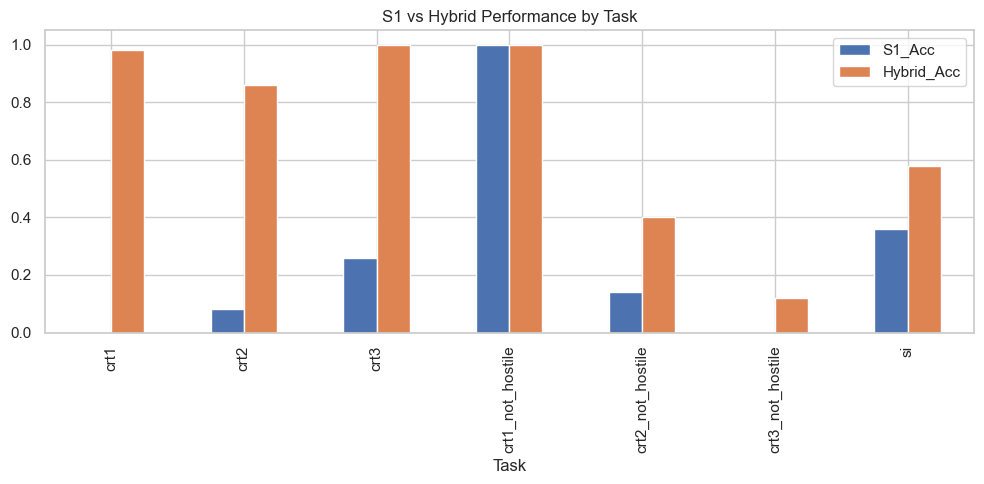

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- 1. 核心过滤逻辑 ---
def find_file_precise(base_path, model_name, task_key, suffix):
    """
    精确匹配文件名，解决 'crt1' 与 'crt1_not_hostile' 的包含冲突
    """
    if not base_path.exists():
        return None
    
    # 搜索模式: {model_name}_{task_key}_{suffix}.csv
    # 这种拼接方式最安全
    exact_name = f"{model_name}_{task_key}_{suffix}.csv"
    target_path = base_path / exact_name
    
    if target_path.exists():
        return target_path
    
    # 如果不存在，尝试遍历并排除干扰项 (以防有微小差异)
    pattern = f"{model_name}*{task_key}*{suffix}.csv"
    matches = list(base_path.glob(pattern))
    
    if "not_hostile" in task_key:
        # 如果找的是 benign，直接取包含该字符的
        matches = [m for m in matches if "not_hostile" in m.name]
    else:
        # 如果找的是 hostile (crt1/2/3)，必须排除掉含有 "not_hostile" 的文件
        matches = [m for m in matches if "not_hostile" not in m.name]
        
    return matches[0] if matches else None

# --- 2. 分析函数 ---
def analyze_task_specific_performance(results_root, s1_name="llama_3_2_3b", s2_name="gemma_2_9b"):
    results_root = Path(results_root)
    
    # 严格对应你的文件名关键字
    TASK_GROUPS = {
        'crt_hostile': ['crt1', 'crt2', 'crt3'],
        'crt_benign': ['crt1_not_hostile', 'crt2_not_hostile', 'crt3_not_hostile'],
        'semantic_inference': ['si']
    }

    task_stats = []
    print(f"--- Starting Precise Analysis: S1={s1_name}, S2={s2_name} ---")

    for group_name, tasks in TASK_GROUPS.items():
        for task in tasks:
            path_s1 = results_root / s1_name / "Splits"
            path_s2 = results_root / s2_name / "Splits"

            file_s1 = find_file_precise(path_s1, s1_name, task, "s1")
            file_s2 = find_file_precise(path_s2, s2_name, task, "s2")
            
            if not file_s1 or not file_s2:
                print(f"[-] Missing: {task} (Searched in {path_s1})")
                continue

            print(f"[+] Processing {group_name}: {file_s1.name}")

            # 读取数据
            df_s1 = pd.read_csv(file_s1)
            df_s2 = pd.read_csv(file_s2)
            
            def to_bool(s):
                return str(s).strip().lower() == 'true'

            # 自动识别 T_F 列
            c1 = [col for col in df_s1.columns if 'T_F' in col or 'is_correct' in col][0]
            c2 = [col for col in df_s2.columns if 'T_F' in col or 'is_correct' in col][0]

            df_s1['res'] = df_s1[c1].apply(to_bool)
            df_s2['res'] = df_s2[c2].apply(to_bool)
            
            merged = pd.merge(df_s1[['id', 'res']], df_s2[['id', 'res']], on='id', suffixes='_s1 _s2'.split())

            if not merged.empty:
                s1_acc = merged['res_s1'].mean()
                hybrid_acc = (merged['res_s1'] | merged['res_s2']).mean()
                
                task_stats.append({
                    'Group': group_name,
                    'Task': task,
                    'S1_Acc': s1_acc,
                    'Hybrid_Acc': hybrid_acc,
                    'Lift': (hybrid_acc - s1_acc) * 100
                })

    if not task_stats:
        print("\n[!] No data found. Check if the model names match folder names exactly.")
        return None

    return pd.DataFrame(task_stats)

def main():
    # 执行分析
    df = analyze_task_specific_performance("./Results", "llama_3_2_3b", "gemma_2_9b")
    
    if df is not None:
        print("\n" + "="*65)
        print(f"{'TASK':<20} | {'S1 ACC':<8} | {'HYBRID':<8} | {'LIFT':<8}")
        print("-" * 65)
        for _, row in df.iterrows():
            print(f"{row['Task']:<20} | {row['S1_Acc']:<8.2f} | {row['Hybrid_Acc']:<8.2f} | {row['Lift']:>+7.1f}%")
        print("="*65)
        
        # 简单绘图验证
        df.set_index('Task')[['S1_Acc', 'Hybrid_Acc']].plot(kind='bar', figsize=(10,5))
        plt.title("S1 vs Hybrid Performance by Task")
        plt.tight_layout()
        plt.savefig("task_comparison.png")

if __name__ == "__main__":
    main()

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# --- 1. 配置区 ---
PRICING = {
    "mistral_8b":   {'in': 0.15, 'out': 0.15, 'is_small': True},
    "qwen_32b":     {'in': 0.08, 'out': 0.24, 'is_small': False},
    "deepseek_v3":  {'in': 0.3,  'out': 1.2,  'is_small': False},
    "qwen_2_5_7b":  {'in': 0.04, 'out': 0.1,  'is_small': True},
    "llama_3_2_3b": {'in': 0.02, 'out': 0.02, 'is_small': True},
    "gemma_2_9b":   {'in': 0.03, 'out': 0.09, 'is_small': True},
}

PERCENTILE_RATIO = 1/np.e 

def run_full_36_analysis(results_root):
    results_root = Path(results_root)
    models = list(PRICING.keys())
    s1_registry = {}
    
    # 1. 预载 S1
    for f in results_root.rglob("*_s1.csv"):
        m_name = next((m for m in models if f.name.startswith(m)), None)
        if m_name:
            task = f.name.replace(f"{m_name}_", "").replace("_s1.csv", "")
            df = pd.read_csv(f)
            df['T_F'] = df['T_F'].map(lambda x: str(x).strip().lower() == 'true')
            s1_registry[(m_name, task)] = df

    final_results = []
    s2_files = list(results_root.rglob("*_s2.csv"))
    
    # 2. 核心计算
    for f_s2 in s2_files:
        s2_m = next((m for m in models if f_s2.name.startswith(m)), None)
        if not s2_m: continue
        s2_task = f_s2.name.replace(f"{s2_m}_", "").replace("_s2.csv", "")
        df_s2 = pd.read_csv(f_s2)
        df_s2['T_F'] = df_s2['T_F'].map(lambda x: str(x).strip().lower() == 'true')

        for s1_m in models:
            if (s1_m, s2_task) not in s1_registry: continue
            
            df_s1 = s1_registry[(s1_m, s2_task)]
            merged = pd.merge(df_s1, df_s2, on='id', suffixes=('_s1', '_s2'))
            if merged.empty: continue

            # --- Scale-Aware Controller 逻辑 ---
            is_small = PRICING[s1_m]['is_small']
            tau_s = np.percentile(merged['s1_confidence'], PERCENTILE_RATIO * 100)
            
            if is_small:
                trigger = (merged['consistency_entropy'] > 0)
            else:
                trigger = (merged['consistency_entropy'] > 0) | (merged['s1_confidence'] <= tau_s)

            # --- 指标计算 ---
            n = len(merged)
            s1_acc = merged['T_F_s1'].mean()
            s2_acc = merged['T_F_s2'].mean()  # 新增：记录该任务下 S2 的独立表现
            
            # Hybrid 结果由 S1 和 触发路由后的 S2 共同决定
            hybrid_acc = (merged['T_F_s1'] | (trigger & merged['T_F_s2'])).mean()
            
            p1, p2 = PRICING[s1_m], PRICING[s2_m]
            c_s1 = (merged['prompt_tokens_s1'].sum() * p1['in'] + n * 20 * p1['out']) * 3 / 1e6
            c_s2 = (merged.loc[trigger, 'prompt_tokens_s2'] * p2['in'] + 
                    merged.loc[trigger, 'completion_tokens_s2'] * p2['out']).sum() / 1e6
            total_cost = (c_s1 + c_s2) * 100

            final_results.append({
                "S1": s1_m, "S2": s2_m, "Task": s2_task,
                "S1_Acc": s1_acc, "S2_Acc": s2_acc, "Hybrid_Acc": hybrid_acc,
                "MU_pts": (hybrid_acc - s1_acc) * 100, "Cost": total_cost
            })

    # --- 3. 聚合与保存 ---
    raw_df = pd.DataFrame(final_results)
    
    # 对 S1_Acc, S2_Acc, Hybrid_Acc 取均值，MU_pts 和 Cost 取总和
    agg_df = raw_df.groupby(['S1', 'S2']).agg({
        'S1_Acc': 'mean', 
        'S2_Acc': 'mean', 
        'Hybrid_Acc': 'mean', 
        'MU_pts': 'sum', 
        'Cost': 'sum'
    }).reset_index()
    
    agg_df['C_Gain'] = agg_df['MU_pts'] / agg_df['Cost']
    agg_df['C_Gain'] = agg_df['C_Gain'].fillna(0)
    
    agg_df = agg_df.sort_values(["S1", "S2"])
    
    # 保存包含 S2_Acc 的 36 行矩阵
    agg_df.to_csv("Scale_Aware_Full_36_Matrix.csv", index=False)
    
    print(f"✅ 处理组合数量: {len(agg_df)}")
    print("✅ 包含 S1/S2/Hybrid 对比的矩阵已保存：Scale_Aware_Full_36_Matrix.csv")
    
    # 打印前 5 行作为预览
    print("\n--- Aggregated Results (Preview) ---")
    cols_to_show = ['S1', 'S2', 'S1_Acc', 'S2_Acc', 'Hybrid_Acc', 'C_Gain']
    print(agg_df[cols_to_show].head().to_string(index=False))
    
    return agg_df

if __name__ == "__main__":
    df = run_full_36_analysis("Results")

✅ 处理组合数量: 36
✅ 包含 S1/S2/Hybrid 对比的矩阵已保存：Scale_Aware_Full_36_Matrix.csv

--- Aggregated Results (Preview) ---
         S1           S2   S1_Acc   S2_Acc  Hybrid_Acc    C_Gain
deepseek_v3  deepseek_v3 0.622857 0.805714    0.851429  9.341533
deepseek_v3   gemma_2_9b 0.622857 0.677143    0.780000 20.733799
deepseek_v3 llama_3_2_3b 0.622857 0.542857    0.757143 19.099495
deepseek_v3   mistral_8b 0.622857 0.408571    0.717143  6.669951
deepseek_v3  qwen_2_5_7b 0.622857 0.705714    0.820000 23.963392
